In [20]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.spatial.distance import cdist
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as pltslinux
import matplotlib.pyplot as plt
import pickle
from multiprocessing import Pool, cpu_count
from itertools import combinations
from collections import defaultdict, Counter
import time
from tqdm import tqdm
import warnings
import psutil
from mlxtend.frequent_patterns import apriori, association_rules
from prettytable import PrettyTable
from PIL import Image, ImageDraw, ImageFont
import networkx as nx

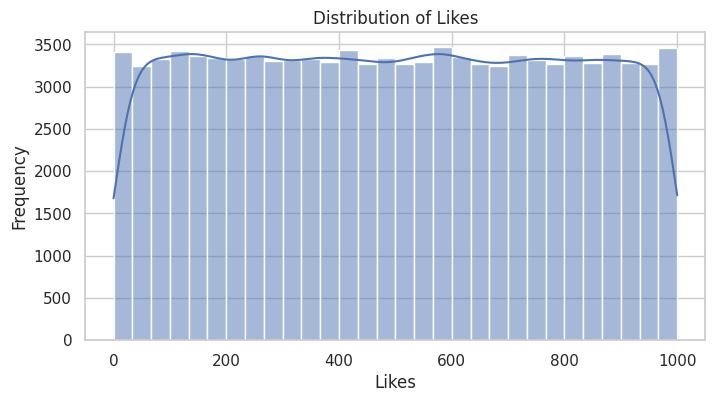

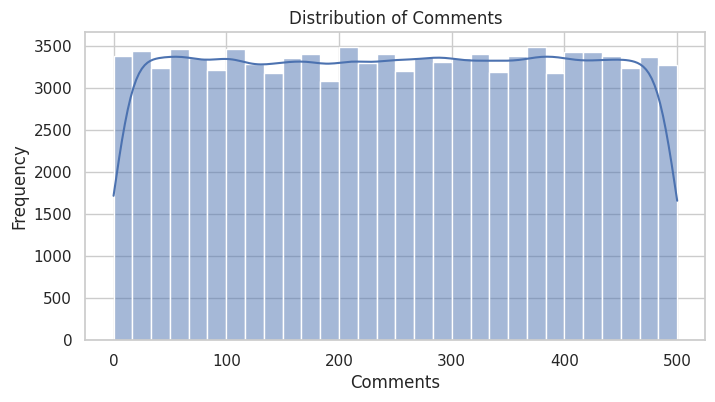

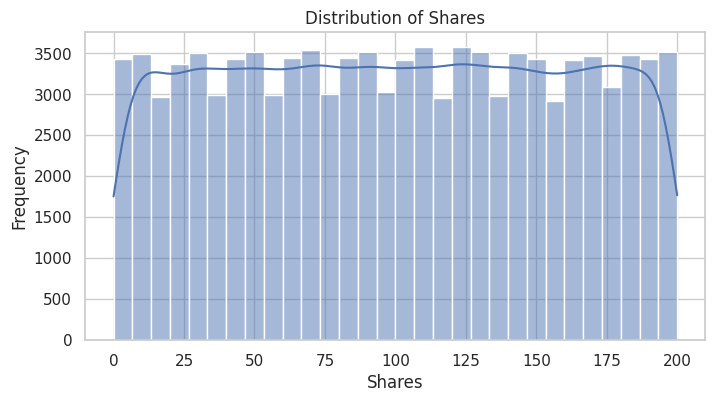

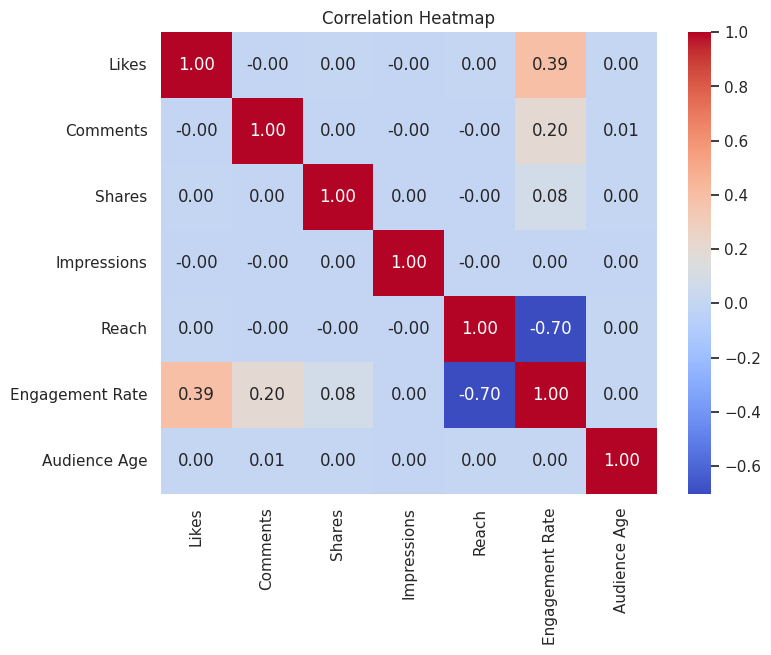

        Platform Post Type                                       Post Content  \
0       LinkedIn     Video                     Want that according same wish.   
1      Instagram     Video                       Increase fast partner south.   
2      Instagram     Video         Lawyer behavior born window couple sister.   
3        Twitter     Image                          Street great decade must.   
4       Facebook      Link  At clear meeting with reason ground continue c...   
...          ...       ...                                                ...   
99995   LinkedIn      Link                          Trial serious region bit.   
99996   Facebook      Link                      Pretty general by scene risk.   
99997   LinkedIn      Link                  Develop school account wish rate.   
99998  Instagram      Link         Just might language idea answer data idea.   
99999    Twitter      Link                            Cold money inside deep.   

               Post Timesta

In [2]:
#Preprocessing and EDA
sns.set(style="whitegrid")

# Get current directory and create results folder
results_dir = os.path.join(os.getcwd(), '/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results')
os.makedirs(results_dir, exist_ok=True)

# Load dataset
file_path = os.path.join(os.getcwd(), '/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/social_media_engagement_data.xlsx')
df = pd.read_excel(file_path)

# --- Data Cleaning ---
df = df.drop_duplicates()  # Remove duplicates

# Drop unnecessary columns
drop_cols = ['Post ID', 'Influencer ID', 'Campaign ID']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Drop rows with missing values in key engagement metrics
key_metrics = ['Likes', 'Comments', 'Shares', 'Impressions', 'Reach']
df = df.dropna(subset=[col for col in key_metrics if col in df.columns])

# Remove negative values
df = df[(df['Likes'] >= 0) & (df['Comments'] >= 0) & (df['Shares'] >= 0)]

# Save cleaned data as a pickle file
pickle_path = os.path.join(results_dir, 'cleaned_data.pkl')
with open(pickle_path, 'wb') as f:
    pickle.dump(df, f)

# --- Exploratory Data Analysis (EDA) ---
# 1. Distribution of engagement metrics
for metric in ['Likes', 'Comments', 'Shares']:
    if metric in df.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[metric], bins=30, kde=True)
        plt.title(f'Distribution of {metric}')
        plt.xlabel(metric)
        plt.ylabel('Frequency')
        plt.savefig(os.path.join(results_dir, f'{metric.lower()}_distribution.png'))
        plt.show()

# 2. Correlation Heatmap
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(8, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.savefig(os.path.join(results_dir, 'correlation_heatmap.png'))
plt.show()

# 3. Engagement Score (Sum of key metrics)
df['Engagement Score'] = df[key_metrics].sum(axis=1)
print(df)

# Save updated data with engagement score as a pickle file
pickle_path_updated = os.path.join(results_dir, 'preprocessed_data.pkl')
with open(pickle_path_updated, 'wb') as f:
    pickle.dump(df, f)

print("Data cleaning and EDA completed. Pickle file saved.")


In [21]:
##Rerun this pickle file - Preprocessed and EDA
with open('/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/preprocessed_data.pkl', 'rb') as f:
    df = pickle.load(f)

print("activated")

activated


In [ ]:
## Incremental clustering and Evaluation Measures

# Create directories for incremental clustering results
results_dir = "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results"
incremental_dir = os.path.join(results_dir, 'incremental_clustering')
incremental_viz_dir = os.path.join(incremental_dir, 'visualizations')
cluster_viz_dir = os.path.join(incremental_dir, 'cluster_visuals')
metric_viz_dir = os.path.join(incremental_dir, 'metrics')
os.makedirs(incremental_dir, exist_ok=True)
os.makedirs(incremental_viz_dir, exist_ok=True)
os.makedirs(cluster_viz_dir, exist_ok=True)
os.makedirs(metric_viz_dir, exist_ok=True)

# Define engagement columns for clustering
engagement_cols = ['Likes', 'Comments', 'Shares', 'Impressions', 'Reach', 'Engagement Score']

# Create a clean copy of the data for clustering
df_clean = df.copy()

# --------------------- INCREMENTAL CLUSTERING ---------------------

# Identify numeric columns for clustering
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
clustering_cols = [col for col in numeric_cols if 'id' not in col.lower() and col in engagement_cols]

print(f"\nColumns used for clustering: {clustering_cols}")

# Initialize the scaler with the entire preprocessed dataset
scaler = StandardScaler()
df_clean_scaled = df_clean.copy()
df_clean_scaled[clustering_cols] = scaler.fit_transform(df_clean[clustering_cols])

# Save scaler parameters for future use
scaler_params = pd.DataFrame({
    'mean': scaler.mean_,
    'scale': scaler.scale_
}, index=clustering_cols)
scaler_params.to_csv(os.path.join(results_dir, 'scaler_parameters.csv'))

# Set parameters for incremental clustering
n_clusters = 3  # Low, Medium, High
chunk_size = 100  # Process 100 samples at a time
n_samples = len(df_clean_scaled)
n_chunks = (n_samples + chunk_size - 1) // chunk_size  # Ceiling division

# Initialize MiniBatchKMeans for incremental clustering
incremental_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    batch_size=chunk_size,
    random_state=42,
    max_iter=100
)

# Initialize dictionaries to store data for each cluster
cluster_data = {i: pd.DataFrame() for i in range(n_clusters)}
cluster_labels = ['low', 'medium', 'high']

# Initialize lists to track metrics across chunks
inertia_values = []
silhouette_values = []
calinski_values = []
davies_values = []
centroid_movement = []
chunk_sizes = []
chunk_indices = []
previous_centroids = None

# Lists to track centroids evolution for visualization
centroids_history = []

# Process data in chunks (simulating streaming data)
for i in range(n_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, n_samples)

    # Get current chunk
    chunk = df_clean_scaled.iloc[start_idx:end_idx].copy()

    # Extract features (already scaled)
    X = chunk[clustering_cols]

    # Partial fit the model with the current chunk
    incremental_kmeans.partial_fit(X)

    # Store current centroids for visualization
    centroids_history.append(incremental_kmeans.cluster_centers_.copy())

    # Track centroid movement
    if previous_centroids is not None:
        movement = np.linalg.norm(incremental_kmeans.cluster_centers_ - previous_centroids, axis=1).mean()
        centroid_movement.append(movement)
    previous_centroids = incremental_kmeans.cluster_centers_.copy()

    # Get cluster assignments for the current chunk
    chunk_labels = incremental_kmeans.predict(X)

    # Add cluster labels to the chunk
    chunk['cluster'] = chunk_labels
    chunk['cluster_name'] = [cluster_labels[label] for label in chunk_labels]

    # Update each cluster's data
    for cluster_idx in range(n_clusters):
        cluster_chunk = chunk[chunk['cluster'] == cluster_idx]
        cluster_data[cluster_idx] = pd.concat([cluster_data[cluster_idx], cluster_chunk])

    # Track chunk size
    chunk_sizes.append(end_idx - start_idx)
    chunk_indices.append(i+1)

    # Calculate metrics for visualization
    # Apply current model to all data seen so far
    if i > 0:  # Need at least 2 clusters to calculate metrics
        all_data_so_far = df_clean_scaled.iloc[:end_idx].copy()
        X_all = all_data_so_far[clustering_cols]
        all_labels = incremental_kmeans.predict(X_all)

        # Calculate metrics
        inertia_values.append(incremental_kmeans.inertia_)

        # Silhouette score is computationally expensive for large datasets
        if len(X_all) > 10000:
            sample_indices = np.random.choice(len(X_all), 10000, replace=False)
            silhouette_values.append(silhouette_score(X_all.iloc[sample_indices], all_labels[sample_indices]))
        else:
            silhouette_values.append(silhouette_score(X_all, all_labels))

        calinski_values.append(calinski_harabasz_score(X_all, all_labels))
        davies_values.append(davies_bouldin_score(X_all, all_labels))

    # Visualize clusters every 5 chunks (optional - can be computationally intensive)
    if (i + 1) % 5 == 0 or (i + 1) == n_chunks:
        # Save current model state
        model_path = os.path.join(incremental_dir, f'kmeans_model_chunk_{i+1}.pkl')
        with open(model_path, 'wb') as f:
            pickle.dump(incremental_kmeans, f)

# After all chunks are processed, determine cluster order based on engagement score
cluster_avg_score = {}
for cluster_idx in cluster_data.keys():
    df_cluster = cluster_data[cluster_idx]
    cluster_avg_score[cluster_idx] = df_cluster['Engagement Score'].mean()

# Sort clusters by average engagement score
sorted_clusters = sorted(cluster_avg_score.items(), key=lambda x: x[1])
cluster_mapping = {
    sorted_clusters[0][0]: 'low',
    sorted_clusters[1][0]: 'medium',
    sorted_clusters[2][0]: 'high'
}

# Create a summary DataFrame for each cluster
cluster_summary = pd.DataFrame(index=engagement_cols + ['count', 'percentage'])

# Process final results based on mapping
for cluster_idx, label in cluster_mapping.items():
    df_final = cluster_data[cluster_idx].copy()
    df_final['engagement_level'] = label

    # Save to results directory
    df_final.to_csv(os.path.join(results_dir, f'{label}_engagement_cluster.csv'), index=False)

    # Pickle each cluster dataframe
    with open(os.path.join(incremental_dir, f'{label}_engagement_cluster.pkl'), 'wb') as f:
        pickle.dump(df_final, f)

    # Compute summary statistics for this cluster
    cluster_summary[label] = [df_final[col].mean() for col in engagement_cols] + \
                           [len(df_final),
                            len(df_final) / n_samples * 100]

    # Print summary
    print(f"\n{label.capitalize()} Engagement Cluster:")
    print(f"Number of records: {len(df_final)}")
    print(f"Average engagement score: {df_final['Engagement Score'].mean():.2f}")
    print(f"Min engagement score: {df_final['Engagement Score'].min():.2f}")
    print(f"Max engagement score: {df_final['Engagement Score'].max():.2f}")

# Save cluster summary
cluster_summary.to_csv(os.path.join(results_dir, 'cluster_summary.csv'))
with open(os.path.join(incremental_dir, 'cluster_summary.pkl'), 'wb') as f:
    pickle.dump(cluster_summary, f)

# Define the objects you want to pickle
objects_to_pickle = {
    'incremental_kmeans': incremental_kmeans,
    'cluster_data': cluster_data,
    'inertia_values': inertia_values,
    'silhouette_values': silhouette_values,
    'calinski_values': calinski_values,
    'davies_values': davies_values,
    'centroid_movement': centroid_movement,
    'chunk_sizes': chunk_sizes,
    'chunk_indices': chunk_indices,
    'centroids_history': centroids_history,
    'scaler_params': scaler_params,
}

# Pickle each object
for obj_name, obj in objects_to_pickle.items():
    with open(os.path.join(incremental_dir, f'{obj_name}.pkl'), 'wb') as f:
        pickle.dump(obj, f)

print("Objects have been pickled successfully.")


Columns used for clustering: ['Likes', 'Comments', 'Shares', 'Impressions', 'Reach', 'Engagement Score']

Low Engagement Cluster:
Number of records: 40286
Average engagement score: -0.96
Min engagement score: -2.48
Max engagement score: 0.13

Medium Engagement Cluster:
Number of records: 27856
Average engagement score: 0.29
Min engagement score: -1.34
Max engagement score: 2.15

High Engagement Cluster:
Number of records: 31858
Average engagement score: 0.96
Min engagement score: -0.27
Max engagement score: 2.48
Objects have been pickled successfully.


In [ ]:
##Rerun pickle
# Define the directory where the pickled files are stored
incremental_dir = "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/incremental_clustering"

# List of objects to load
objects_to_load = [
    'incremental_kmeans',
    'cluster_data',
    'inertia_values',
    'silhouette_values',
    'calinski_values',
    'davies_values',
    'centroid_movement',
    'chunk_sizes',
    'chunk_indices',
    'centroids_history',
    'scaler_params',
]

# Load each object
loaded_objects = {}
for obj_name in objects_to_load:
    with open(os.path.join(incremental_dir, f'{obj_name}.pkl'), 'rb') as f:
        loaded_objects[obj_name] = pickle.load(f)

# Unpack loaded objects into the current namespace
for obj_name, obj in loaded_objects.items():
    globals()[obj_name] = obj

print("Objects have been loaded successfully.")

Objects have been loaded successfully.


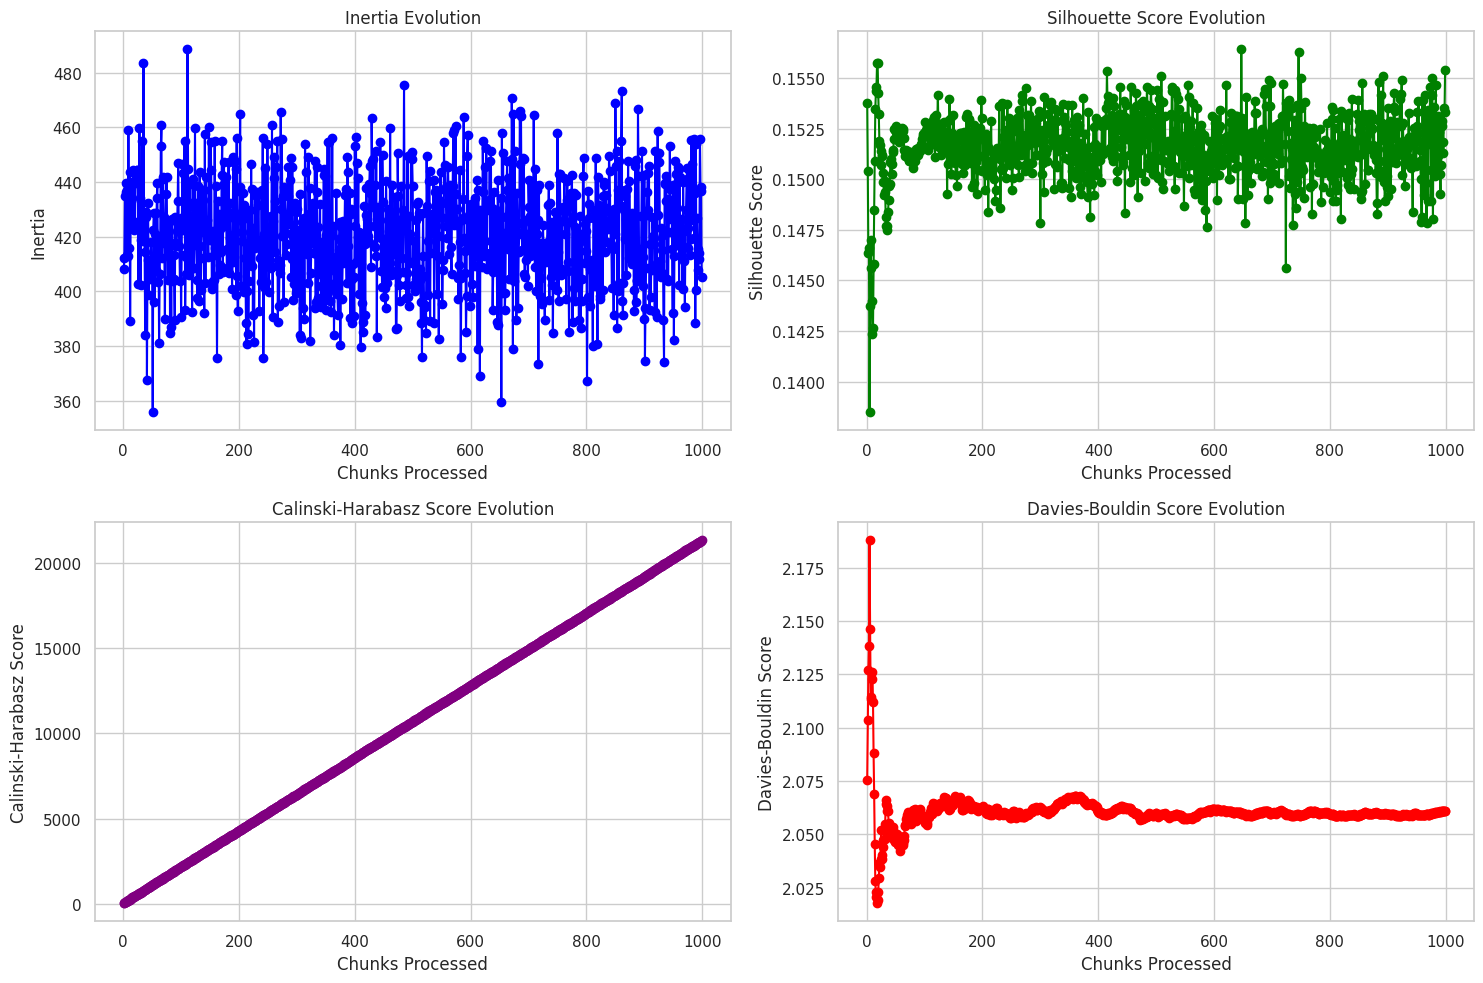

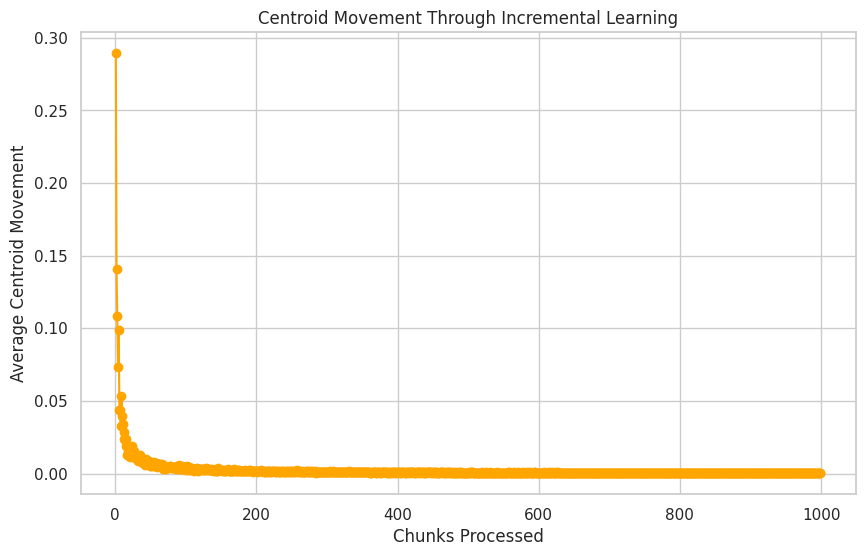

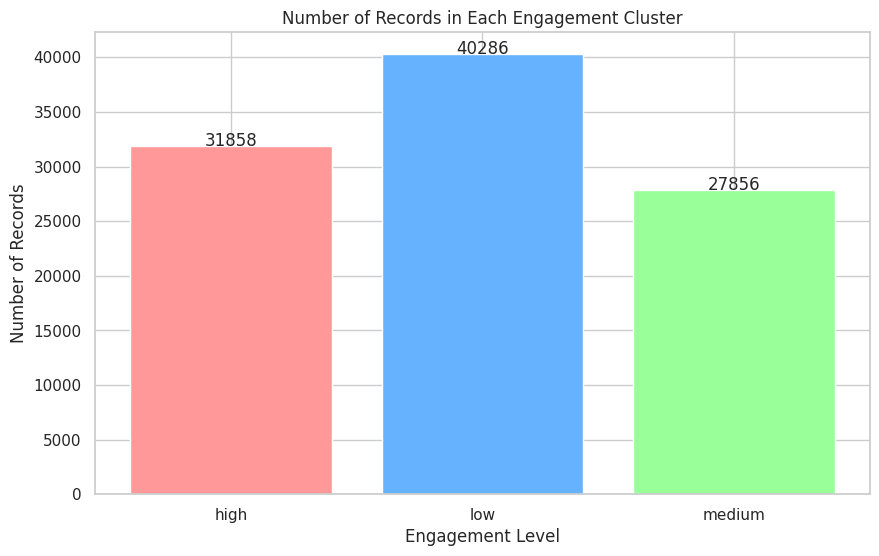

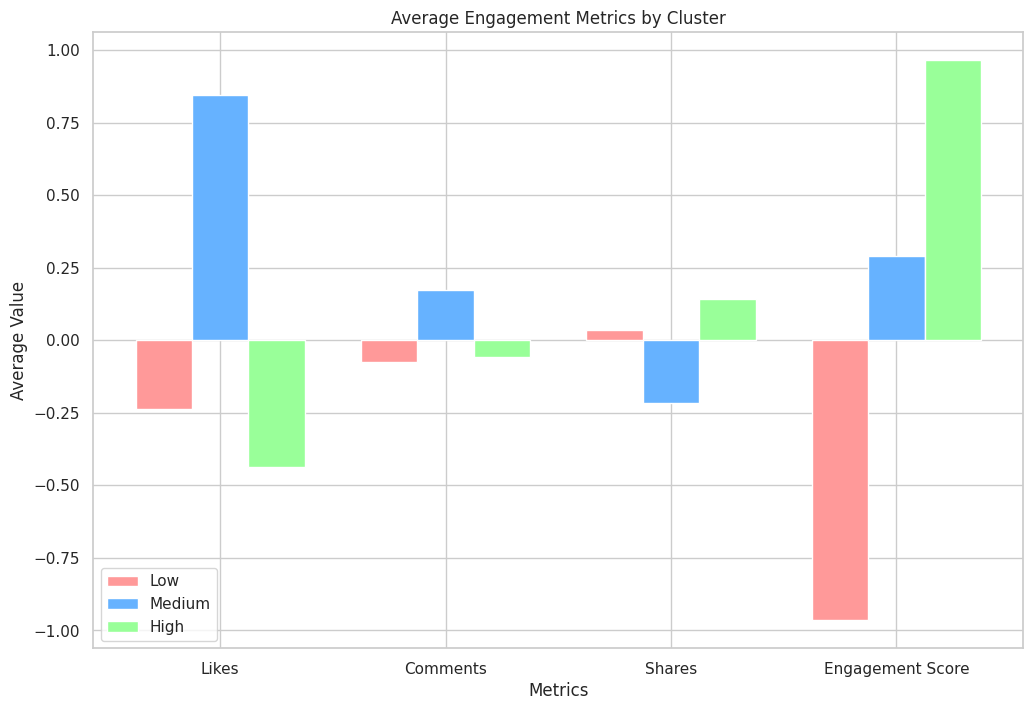

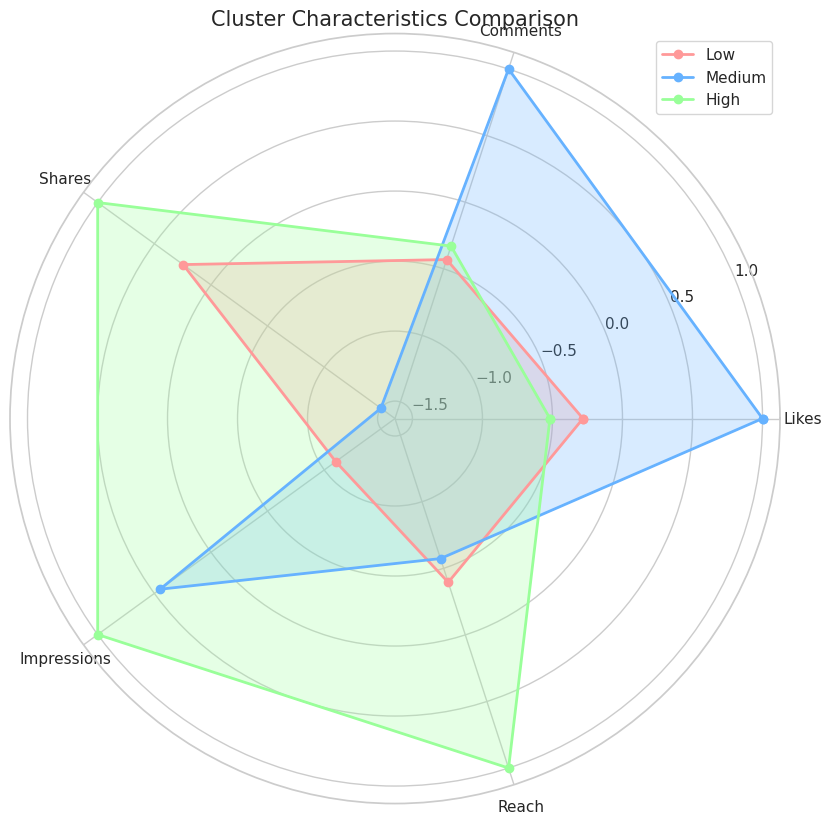

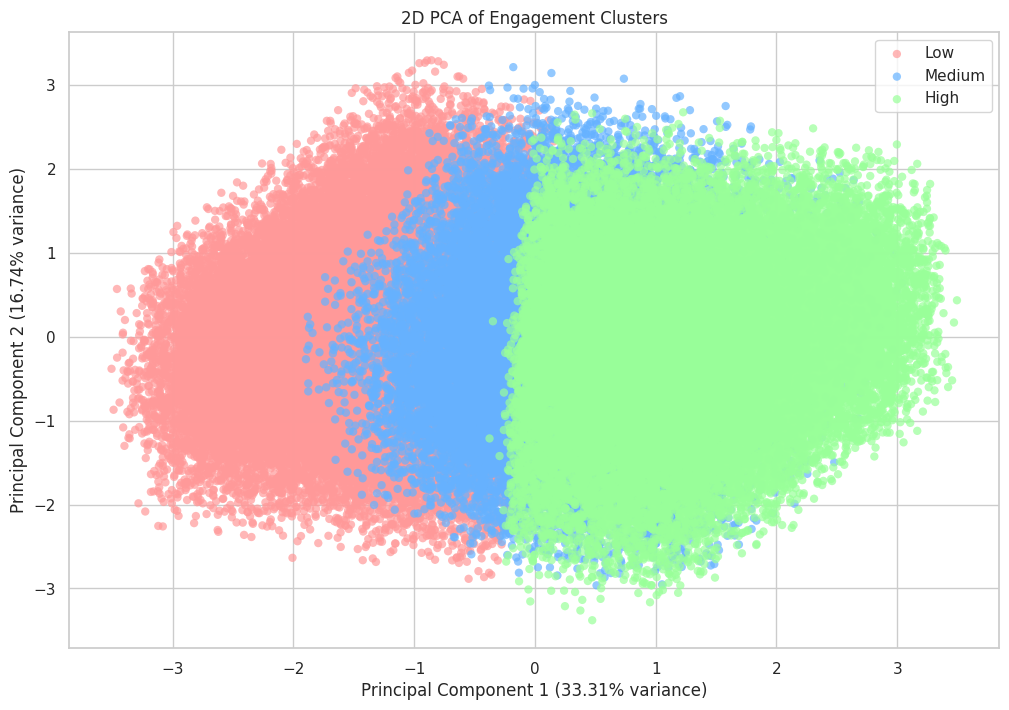

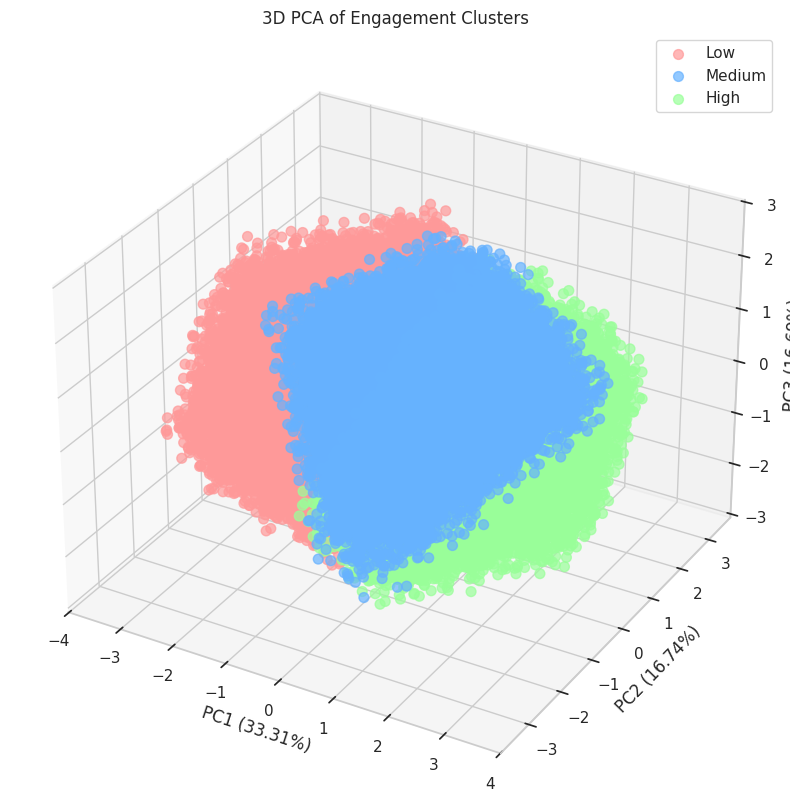

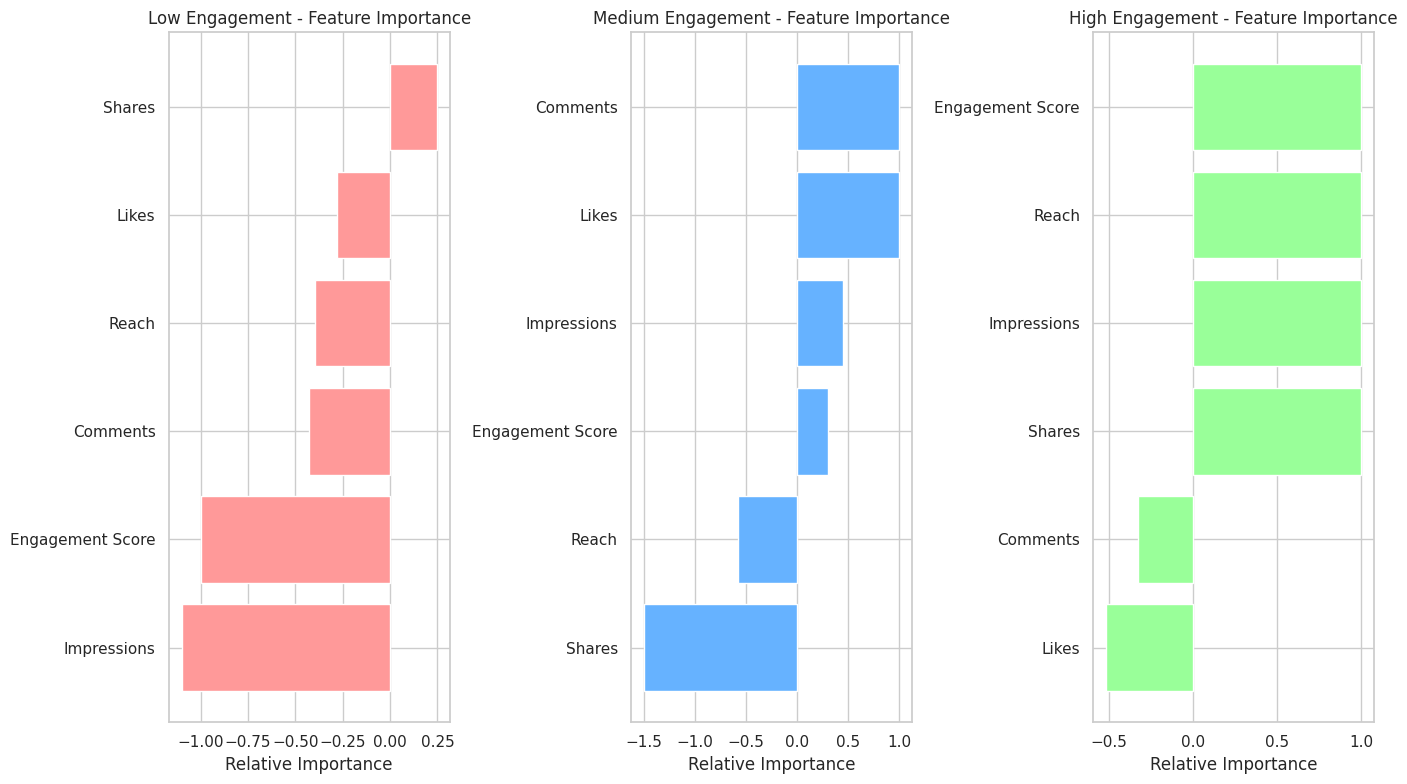

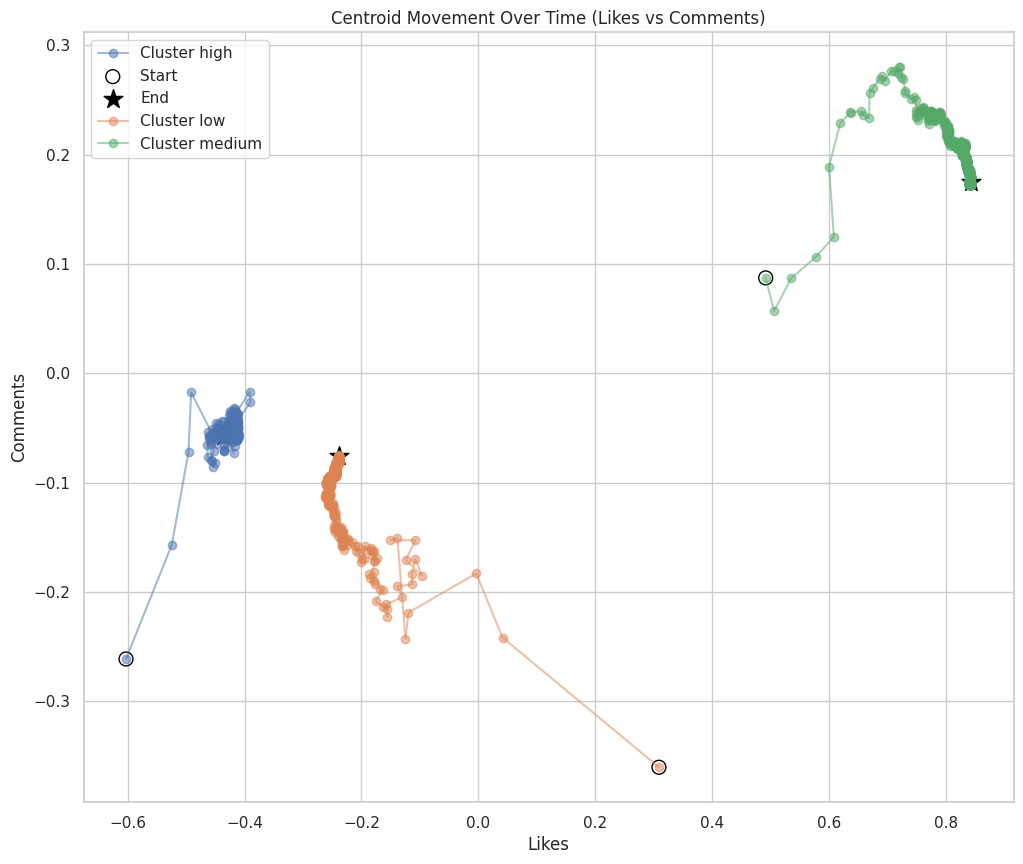

<Figure size 2000x1500 with 0 Axes>

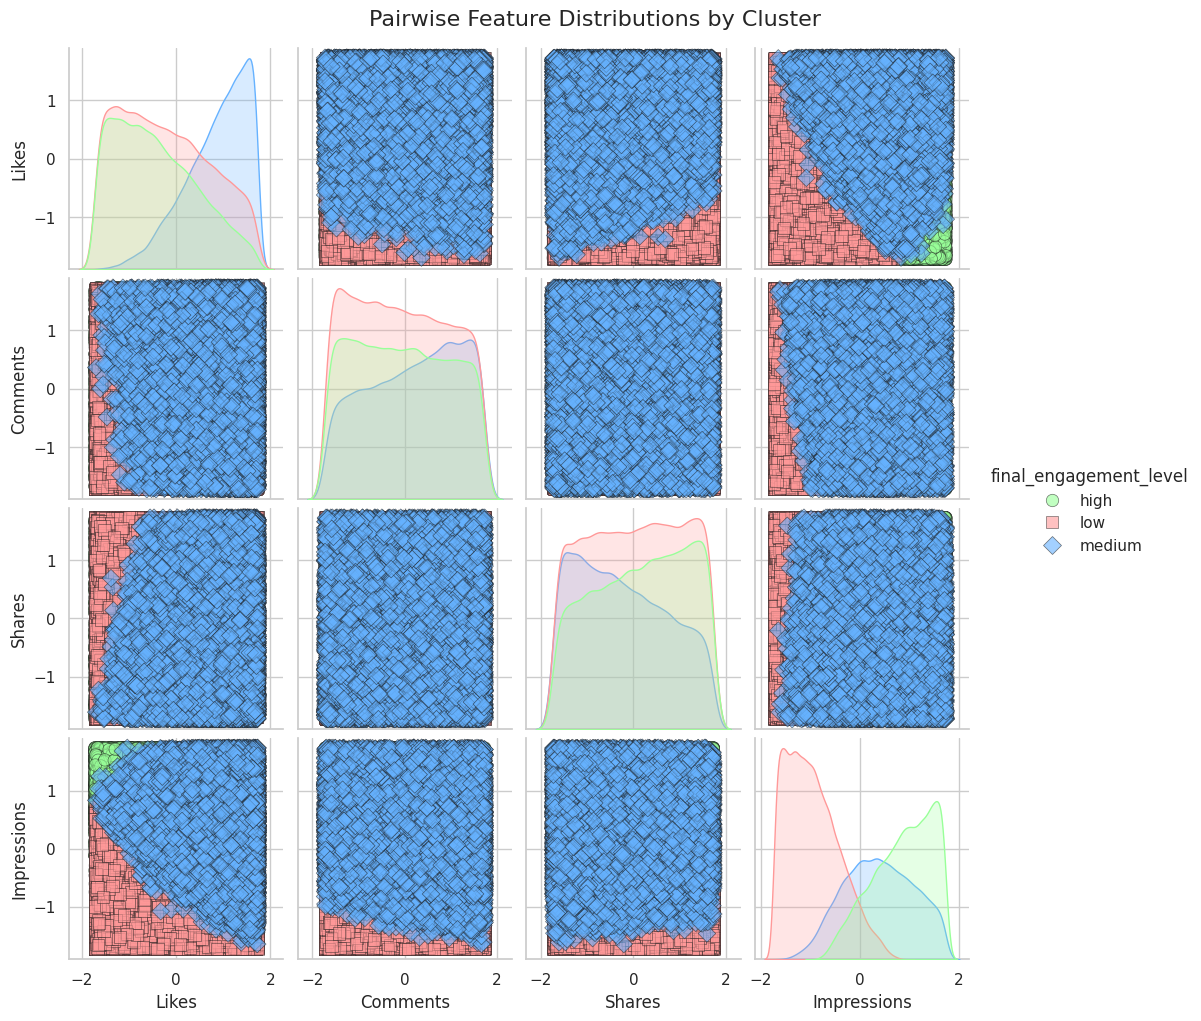

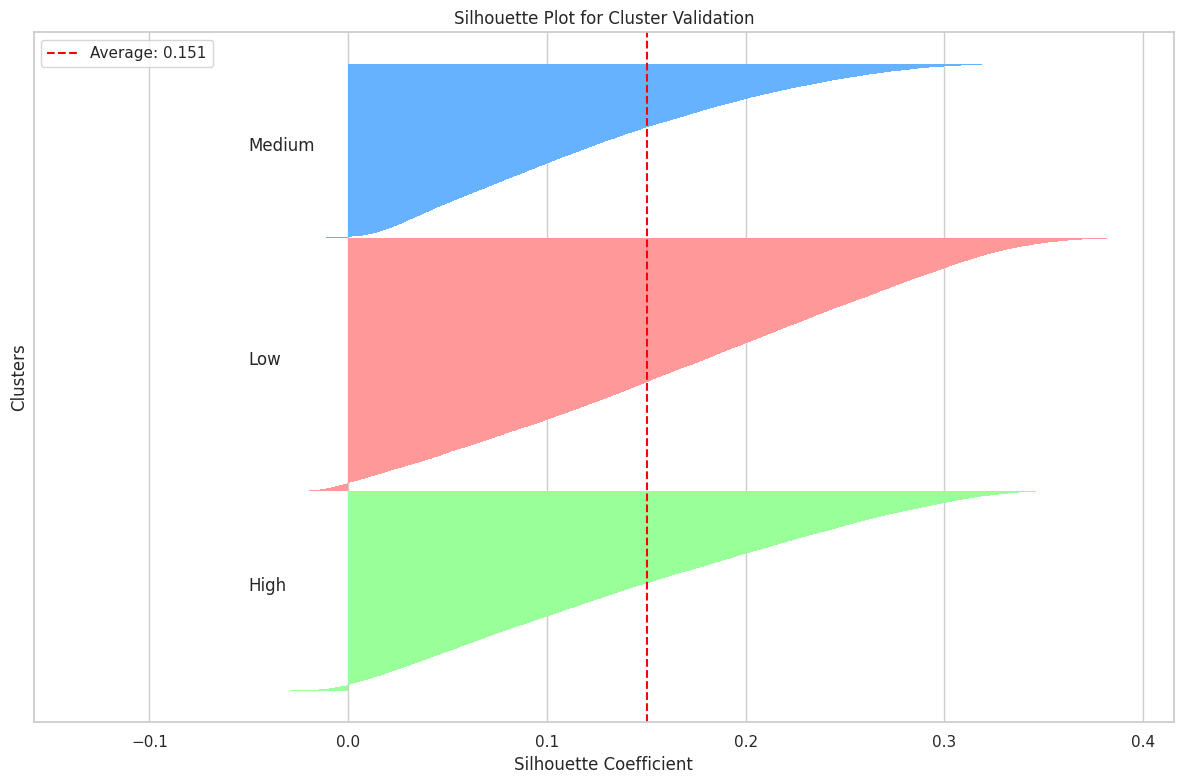

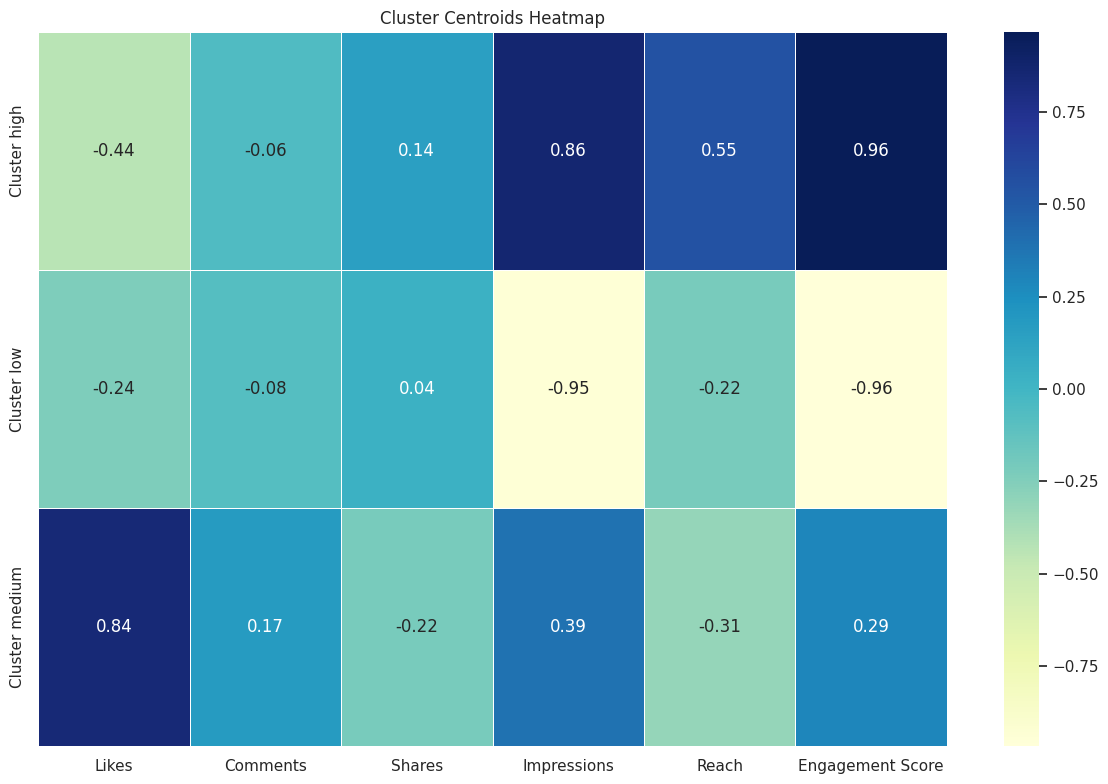

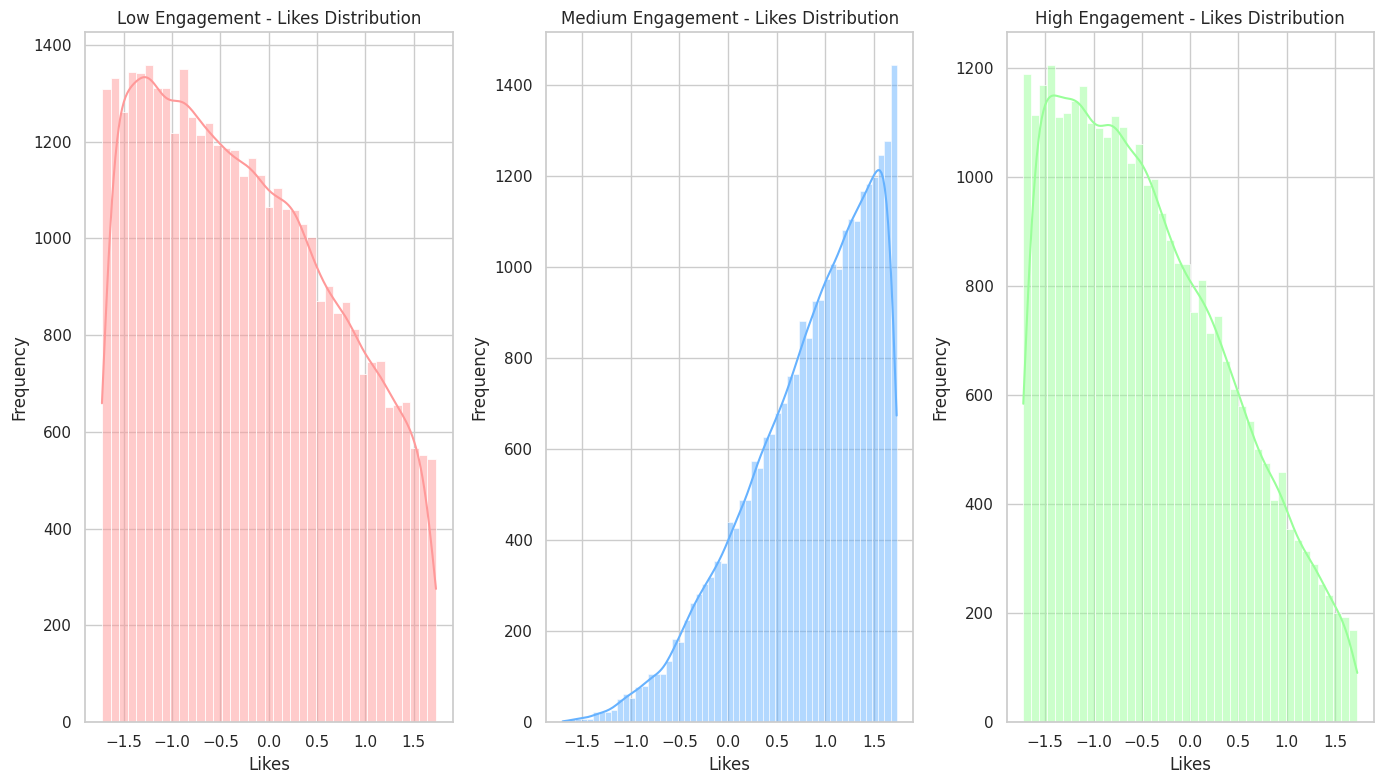

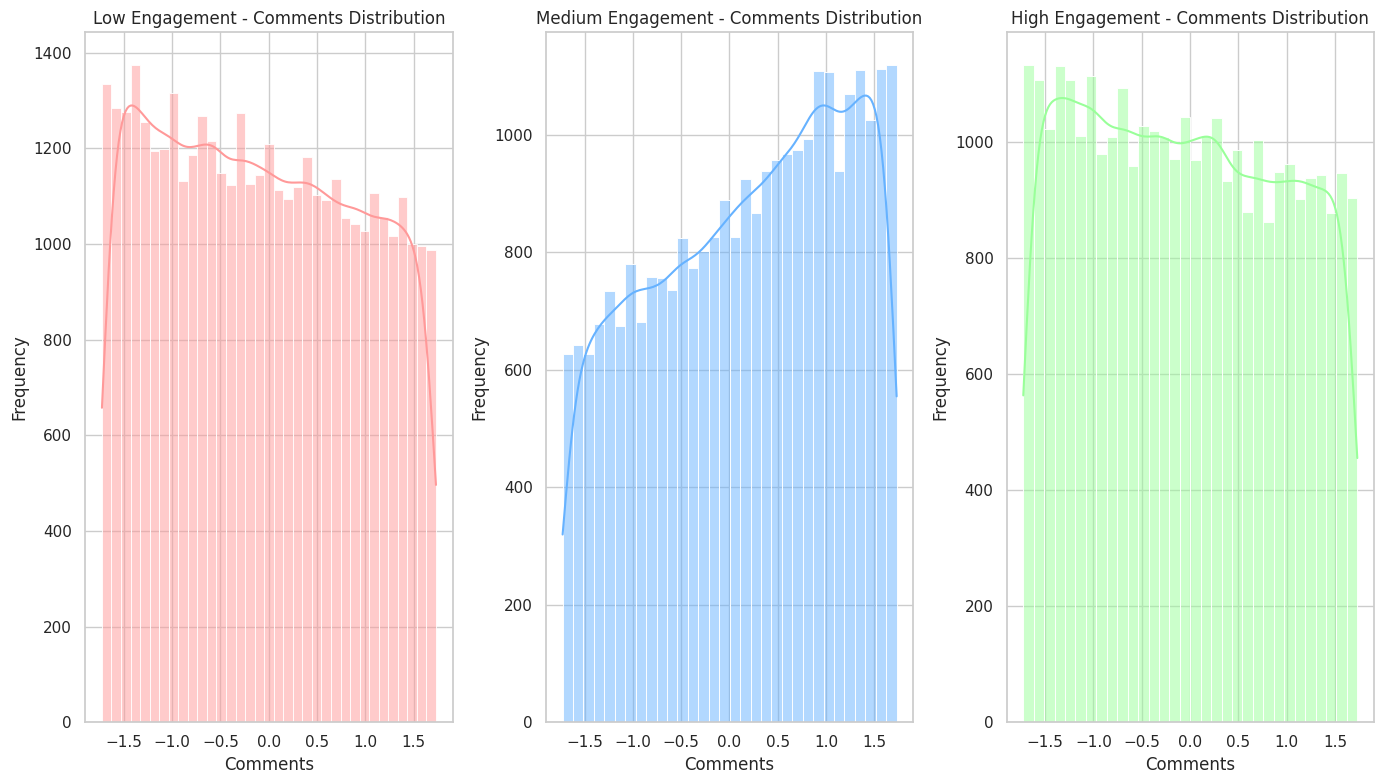

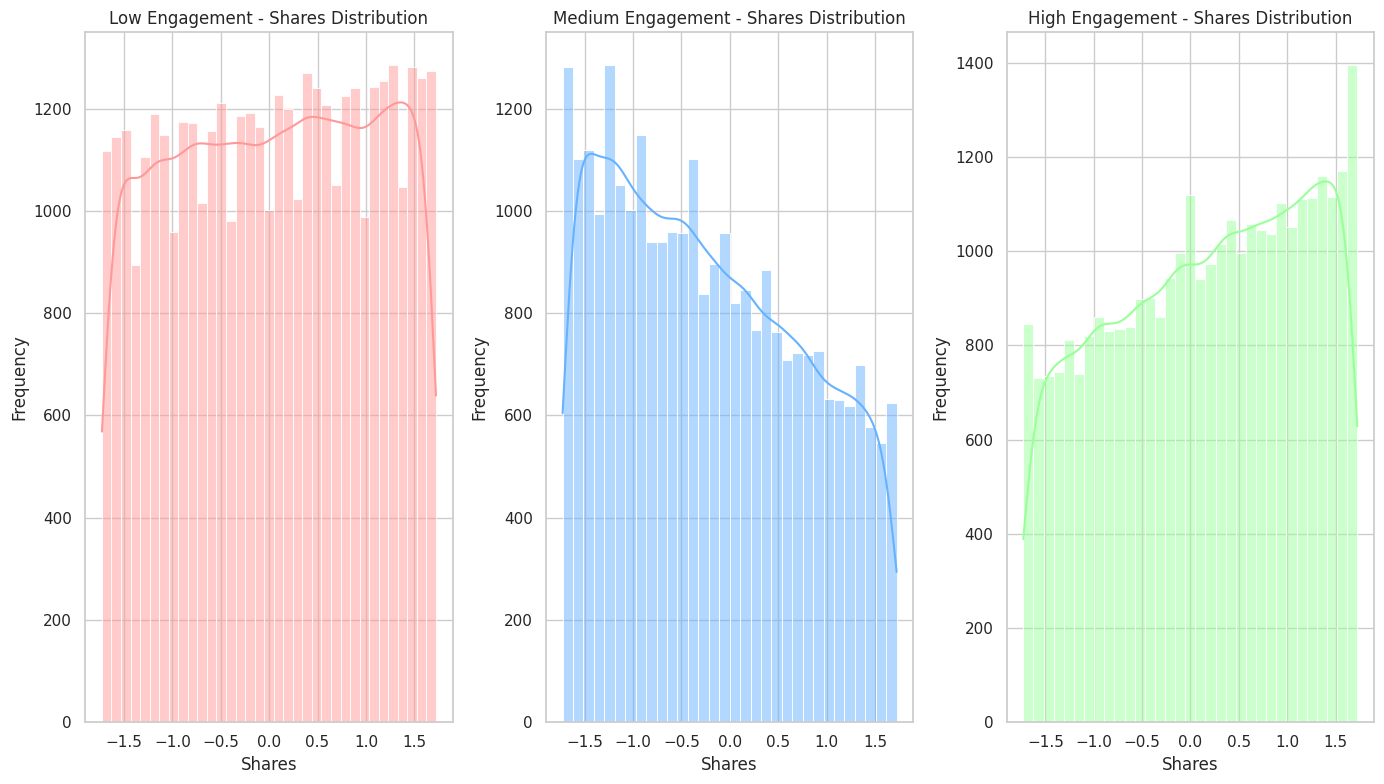

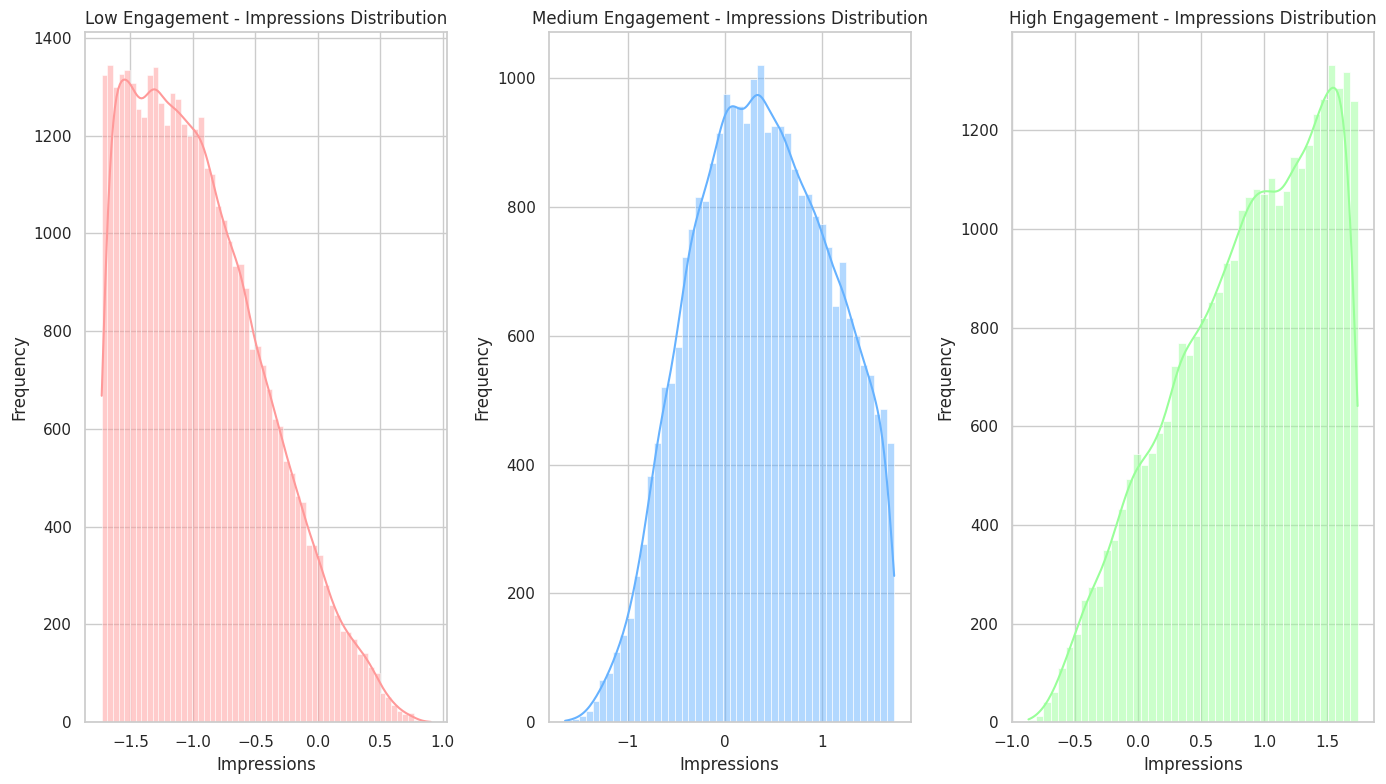

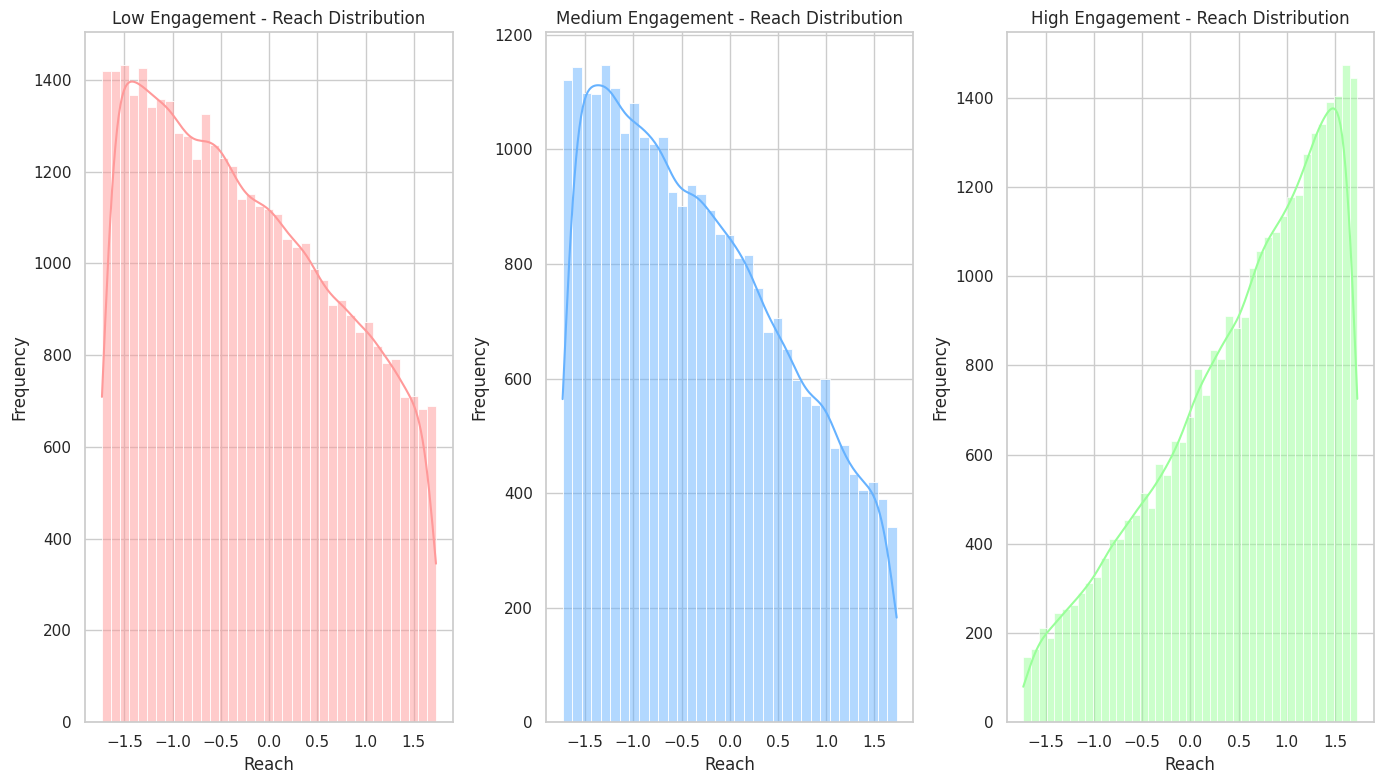

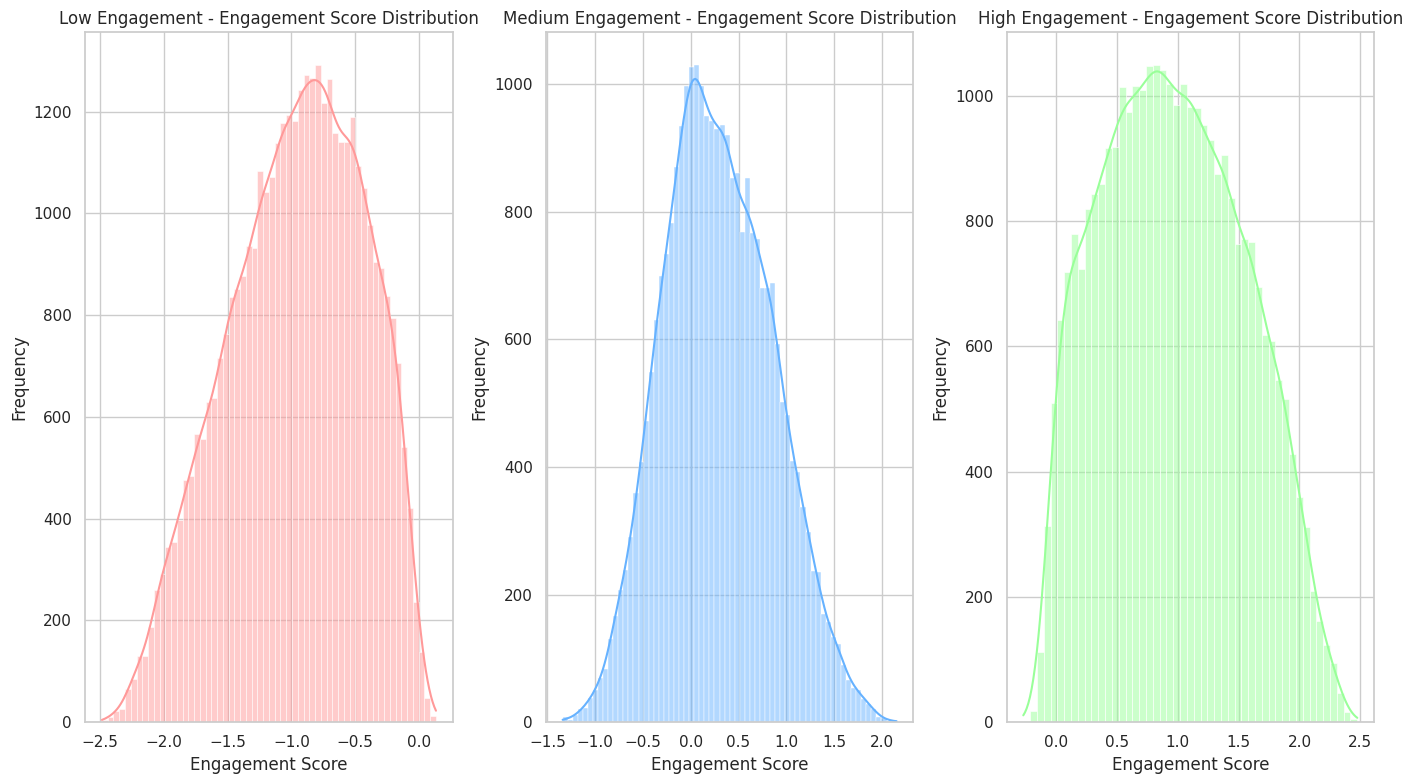


Incremental clustering completed successfully.
All model files and results saved to: /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/incremental_clustering
Use 'final_incremental_model.pkl' for loading the complete model.
Use 'predict_function.pkl' to load the prediction function for new data.
Cluster visualizations saved to: /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/incremental_clustering/cluster_visuals
Metrics visualizations saved to: /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/incremental_clustering/metrics


In [ ]:
# --------------------- VISUALIZATIONS ---------------------

# 1. Plot evaluation metrics evolution through incremental learning
plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2)

# Inertia (lower is better)
ax1 = plt.subplot(gs[0, 0])
ax1.plot(chunk_indices[:-1], inertia_values, marker='o', linestyle='-', color='blue')
ax1.set_title('Inertia Evolution')
ax1.set_xlabel('Chunks Processed')
ax1.set_ylabel('Inertia')
ax1.grid(True)

# Silhouette Score (higher is better)
ax2 = plt.subplot(gs[0, 1])
ax2.plot(chunk_indices[:-1], silhouette_values, marker='o', linestyle='-', color='green')
ax2.set_title('Silhouette Score Evolution')
ax2.set_xlabel('Chunks Processed')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

# Calinski-Harabasz Score (higher is better)
ax3 = plt.subplot(gs[1, 0])
ax3.plot(chunk_indices[:-1], calinski_values, marker='o', linestyle='-', color='purple')
ax3.set_title('Calinski-Harabasz Score Evolution')
ax3.set_xlabel('Chunks Processed')
ax3.set_ylabel('Calinski-Harabasz Score')
ax3.grid(True)

# Davies-Bouldin Score (lower is better)
ax4 = plt.subplot(gs[1, 1])
ax4.plot(chunk_indices[:-1], davies_values, marker='o', linestyle='-', color='red')
ax4.set_title('Davies-Bouldin Score Evolution')
ax4.set_xlabel('Chunks Processed')
ax4.set_ylabel('Davies-Bouldin Score')
ax4.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(metric_viz_dir, 'clustering_metrics_evolution.png'))
plt.show()

# 2. Visualize centroid movement
if len(centroid_movement) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(centroid_movement) + 1), centroid_movement, marker='o', linestyle='-', color='orange')
    plt.title('Centroid Movement Through Incremental Learning')
    plt.xlabel('Chunks Processed')
    plt.ylabel('Average Centroid Movement')
    plt.grid(True)
    plt.savefig(os.path.join(metric_viz_dir, 'centroid_movement.png'))
    plt.show()

# 3. Visualize final cluster distribution
plt.figure(figsize=(10, 6))
cluster_sizes = [len(cluster_data[i]) for i in cluster_data.keys()]
cluster_names = [cluster_mapping.get(i, str(i)) for i in cluster_data.keys()]
colors = ['#FF9999', '#66B2FF', '#99FF99']

plt.bar(cluster_names, cluster_sizes, color=colors)
plt.title('Number of Records in Each Engagement Cluster')
plt.xlabel('Engagement Level')
plt.ylabel('Number of Records')
for i, v in enumerate(cluster_sizes):
    plt.text(i, v + 50, str(v), ha='center')
plt.savefig(os.path.join(cluster_viz_dir, 'cluster_distribution.png'))
plt.show()

# 4. Visualize cluster characteristics
plt.figure(figsize=(12, 8))
metrics_to_plot = ['Likes', 'Comments', 'Shares', 'Engagement Score']
cluster_means = {label: [] for label in cluster_mapping.values()}

for label in cluster_mapping.values():
    for metric in metrics_to_plot:
        cluster_means[label].append(cluster_summary.loc[metric, label])

x = np.arange(len(metrics_to_plot))
width = 0.25
colors = ['#FF9999', '#66B2FF', '#99FF99']

for i, (label, means) in enumerate(cluster_means.items()):
    plt.bar(x + i*width, means, width, label=label.capitalize(), color=colors[i])

plt.xlabel('Metrics')
plt.ylabel('Average Value')
plt.title('Average Engagement Metrics by Cluster')
plt.xticks(x + width, metrics_to_plot)
plt.legend()
plt.grid(True, axis='y')
plt.savefig(os.path.join(cluster_viz_dir, 'cluster_characteristics.png'))
plt.show()

# 5. Create radar chart for cluster comparison
metrics = ['Likes', 'Comments', 'Shares', 'Impressions', 'Reach']

# Normalize the metrics for radar chart
max_values = {metric: cluster_summary.loc[metric, :].max() for metric in metrics}
normalized_data = {}

for label in cluster_mapping.values():
    normalized_data[label] = [cluster_summary.loc[metric, label] / max_values[metric] for metric in metrics]

# Set up the radar chart
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
colors = ['#FF9999', '#66B2FF', '#99FF99']

for i, (label, values) in enumerate(normalized_data.items()):
    values += values[:1]  # Close the loop
    ax.plot(angles, values, 'o-', linewidth=2, label=label.capitalize(), color=colors[i])
    ax.fill(angles, values, alpha=0.25, color=colors[i])

ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
ax.set_title('Cluster Characteristics Comparison', size=15)
ax.grid(True)
ax.legend(loc='upper right')
plt.savefig(os.path.join(cluster_viz_dir, 'cluster_radar_chart.png'))
plt.show()

# 6. PCA to visualize clusters in 2D and 3D
# First, create a combined dataset with all clusters
final_df = pd.concat([cluster_data[i] for i in cluster_data.keys()])
final_df['final_engagement_level'] = final_df['cluster'].map(cluster_mapping)

# Perform PCA for visualization
pca = PCA(n_components=3)
pca_result = pca.fit_transform(final_df[clustering_cols])
final_df['pca_1'] = pca_result[:, 0]
final_df['pca_2'] = pca_result[:, 1]
final_df['pca_3'] = pca_result[:, 2]

# Create 2D PCA scatter plot
plt.figure(figsize=(12, 8))
colors = {'low': '#FF9999', 'medium': '#66B2FF', 'high': '#99FF99'}

for level in ['low', 'medium', 'high']:
    subset = final_df[final_df['final_engagement_level'] == level]
    plt.scatter(
        subset['pca_1'],
        subset['pca_2'],
        c=colors[level],
        label=level.capitalize(),
        alpha=0.7,
        edgecolors='none'
    )

plt.title('2D PCA of Engagement Clusters')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(cluster_viz_dir, 'pca_2d_clusters.png'))
plt.show()

# Create 3D PCA visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for level in ['low', 'medium', 'high']:
    subset = final_df[final_df['final_engagement_level'] == level]
    ax.scatter(
        subset['pca_1'],
        subset['pca_2'],
        subset['pca_3'],
        c=colors[level],
        label=level.capitalize(),
        alpha=0.7,
        s=50
    )

ax.set_title('3D PCA of Engagement Clusters')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')
ax.legend()
plt.savefig(os.path.join(cluster_viz_dir, 'pca_3d_clusters.png'))
plt.show()

# 7. Visualize feature importance for each cluster
plt.figure(figsize=(14, 8))
for i, label in enumerate(cluster_mapping.values()):
    plt.subplot(1, 3, i + 1)
    features = clustering_cols
    importance = cluster_summary.loc[features, label] / cluster_summary.loc[features, :].max(axis=1)

    # Sort by importance
    sorted_idx = np.argsort(importance.values)
    # Get color based on cluster label, not index
    color = colors.get(label, 'gray')
    plt.barh(range(len(features)), importance.values[sorted_idx], color=color)
    plt.yticks(range(len(features)), [features[j] for j in sorted_idx])
    plt.title(f'{label.capitalize()} Engagement - Feature Importance')
    plt.xlabel('Relative Importance')
    plt.tight_layout()

plt.savefig(os.path.join(cluster_viz_dir, 'feature_importance.png'))
plt.show()

# 8. Visualize the centroids movement over time (for the first 2 dimensions)
if len(centroids_history) > 5:  # Only if we have enough data points
    # Choose two features for visualization
    feature_idx1 = 0  # First feature
    feature_idx2 = 1  # Second feature

    feature_names = [clustering_cols[feature_idx1], clustering_cols[feature_idx2]]

    plt.figure(figsize=(12, 10))

    # Plot centroids movement trajectories
    for cluster_idx in range(n_clusters):
        # Extract centroid positions for this cluster over time
        trajectory_x = [centroids[cluster_idx][feature_idx1] for centroids in centroids_history]
        trajectory_y = [centroids[cluster_idx][feature_idx2] for centroids in centroids_history]

        # Plot the trajectory
        plt.plot(trajectory_x, trajectory_y, '-o', alpha=0.5,
                 label=f"Cluster {cluster_mapping[cluster_idx]}")

        # Highlight start and end points
        plt.scatter(trajectory_x[0], trajectory_y[0], marker='o', s=100,
                    facecolors='none', edgecolors='black', label='Start' if cluster_idx == 0 else None)
        plt.scatter(trajectory_x[-1], trajectory_y[-1], marker='*', s=200,
                    color='black', label='End' if cluster_idx == 0 else None)

    plt.title(f'Centroid Movement Over Time ({feature_names[0]} vs {feature_names[1]})')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(cluster_viz_dir, 'centroid_trajectories.png'))
    plt.show()

# 9. Visualize pairwise feature distributions for each cluster
plt.figure(figsize=(20, 15))
g = sns.pairplot(
    final_df,
    vars=clustering_cols[:4],  # Using first 4 features to keep it readable
    hue='final_engagement_level',
    palette=colors,
    markers=["o", "s", "D"],
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k', 'linewidth': 0.5}
)
g.fig.suptitle('Pairwise Feature Distributions by Cluster', y=1.02, fontsize=16)
plt.savefig(os.path.join(cluster_viz_dir, 'pairwise_distributions.png'))
plt.show()

# 10. Silhouette plot for cluster validation
from sklearn.metrics import silhouette_samples

plt.figure(figsize=(12, 8))

# Get silhouette scores for each sample
X = final_df[clustering_cols].values
cluster_labels = final_df['cluster'].values
silhouette_vals = silhouette_samples(X, cluster_labels)

# Sort by cluster and silhouette coefficient
y_lower, y_upper = 0, 0
cluster_silhouette_vals = {}
cluster_silhouette_widths = {}

for i in range(n_clusters):
    cluster_silhouette_vals[i] = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals[i].sort()
    cluster_silhouette_widths[i] = cluster_silhouette_vals[i].shape[0]

    y_upper += cluster_silhouette_widths[i]

    cluster_label = cluster_mapping[i]

    color = colors[cluster_label]
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals[i],
             height=1.0, edgecolor='none', color=color)

    plt.text(-0.05, (y_lower + y_upper) / 2, cluster_label.capitalize())
    y_lower += cluster_silhouette_widths[i]

# Get average silhouette score
avg_score = np.mean(silhouette_vals)
plt.axvline(avg_score, color="red", linestyle="--",
            label=f'Average: {avg_score:.3f}')

plt.yticks([])
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Clusters")
plt.title("Silhouette Plot for Cluster Validation")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(os.path.join(cluster_viz_dir, 'silhouette_plot.png'))
plt.show()

# 11. Heatmap of cluster centroids
plt.figure(figsize=(12, 8))
final_centroids = incremental_kmeans.cluster_centers_

# Create a DataFrame with the centroids
centroid_df = pd.DataFrame(
    final_centroids,
    columns=clustering_cols,
    index=[f"Cluster {cluster_mapping[i]}" for i in range(n_clusters)]
)

# Plot heatmap
sns.heatmap(centroid_df, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
plt.title('Cluster Centroids Heatmap')
plt.tight_layout()
plt.savefig(os.path.join(cluster_viz_dir, 'centroid_heatmap.png'))
plt.show()

# 12. Visualize data distribution within each cluster for each feature
for feature in clustering_cols:
    plt.figure(figsize=(14, 8))

    for i, level in enumerate(['low', 'medium', 'high']):
        plt.subplot(1, 3, i+1)
        subset = final_df[final_df['final_engagement_level'] == level]

        sns.histplot(subset[feature], kde=True, color=colors[level])
        plt.title(f'{level.capitalize()} Engagement - {feature} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.savefig(os.path.join(cluster_viz_dir, f'{feature}_distribution_by_cluster.png'))
    plt.show()

# Save final combined dataset with cluster assignments
final_df.to_csv(os.path.join(results_dir, 'all_engagement_classified.csv'), index=False)
with open(os.path.join(incremental_dir, 'all_engagement_classified.pkl'), 'wb') as f:
    pickle.dump(final_df, f)

# Save final model with its metadata
model_metadata = {
    'model': incremental_kmeans,
    'cluster_mapping': cluster_mapping,
    'scaler': scaler,
    'clustering_cols': clustering_cols,
    'metrics': {
        'final_inertia': incremental_kmeans.inertia_,
        'silhouette_values': silhouette_values,
        'calinski_values': calinski_values,
        'davies_values': davies_values
    }
}

with open(os.path.join(incremental_dir, 'final_incremental_model.pkl'), 'wb') as f:
    pickle.dump(model_metadata, f)

# Create a function to predict clusters for new data
def predict_engagement_level(new_data, model_metadata):
    # Extract components from metadata
    model = model_metadata['model']
    scaler = model_metadata['scaler']
    cluster_mapping = model_metadata['cluster_mapping']
    clustering_cols = model_metadata['clustering_cols']

    # Ensure all required columns are present
    for col in clustering_cols:
        if col not in new_data.columns:
            if col == 'Engagement Score' and all(x in new_data.columns for x in ['Likes', 'Comments', 'Shares', 'Impressions', 'Reach']):
                # Calculate Engagement Score if other metrics are available
                new_data['Engagement Score'] = new_data[['Likes', 'Comments', 'Shares', 'Impressions', 'Reach']].sum(axis=1)
            else:
                raise ValueError(f"Required column {col} missing from input data")

    # Scale the data
    new_data_scaled = new_data.copy()
    new_data_scaled[clustering_cols] = scaler.transform(new_data[clustering_cols])

    # Predict clusters
    cluster_ids = model.predict(new_data_scaled[clustering_cols])

    # Map cluster IDs to engagement levels
    new_data['cluster_id'] = cluster_ids
    new_data['engagement_level'] = [cluster_mapping[cluster_id] for cluster_id in cluster_ids]

    return new_data

# Save the prediction function for future use
with open(os.path.join(incremental_dir, 'predict_function.pkl'), 'wb') as f:
    pickle.dump(predict_engagement_level, f)

print("\nIncremental clustering completed successfully.")
print(f"All model files and results saved to: {incremental_dir}")
print(f"Use 'final_incremental_model.pkl' for loading the complete model.")
print(f"Use 'predict_function.pkl' to load the prediction function for new data.")
print(f"Cluster visualizations saved to: {cluster_viz_dir}")
print(f"Metrics visualizations saved to: {metric_viz_dir}")



In [ ]:
##rerun pickle
##Model prediction pickle
incremental_dir = "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/incremental_clustering"

# Define the predict_engagement_level function before unpickling
def predict_engagement_level(new_data, model_metadata):
    # Extract components from metadata
    model = model_metadata['model']
    scaler = model_metadata['scaler']
    cluster_mapping = model_metadata['cluster_mapping']
    clustering_cols = model_metadata['clustering_cols']

    # Ensure all required columns are present
    for col in clustering_cols:
        if col not in new_data.columns:
            if col == 'Engagement Score' and all(x in new_data.columns for x in ['Likes', 'Comments', 'Shares', 'Impressions', 'Reach']):
                # Calculate Engagement Score if other metrics are available
                new_data['Engagement Score'] = new_data[['Likes', 'Comments', 'Shares', 'Impressions', 'Reach']].sum(axis=1)
            else:
                raise ValueError(f"Required column {col} missing from input data")

    # Scale the data
    new_data_scaled = new_data.copy()
    new_data_scaled[clustering_cols] = scaler.transform(new_data[clustering_cols])

    # Predict clusters
    cluster_ids = model.predict(new_data_scaled[clustering_cols])

    # Map cluster IDs to engagement levels
    new_data['cluster_id'] = cluster_ids
    new_data['engagement_level'] = [cluster_mapping[cluster_id] for cluster_id in cluster_ids]

    return new_data

# Now you can safely load the pickled function
with open(os.path.join(incremental_dir, '/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/incremental_clustering/final_incremental_model.pkl'), 'rb') as f:
    loaded_model_metadata = pickle.load(f)

with open(os.path.join(incremental_dir, '/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/incremental_clustering/predict_function.pkl'), 'rb') as f:
    predict_function = pickle.load(f)

# Example new data
new_data = pd.DataFrame({
    'Likes': [100, 200000, 50],
    'Comments': [10, 300000, 5],
    'Shares': [5, 150000, 2],
    'Impressions': [1000, 200000, 500],
    'Reach': [800, 150000, 400]
})

# Make predictions
predictions = predict_function(new_data, loaded_model_metadata)
print("Example predictions:")
print(predictions[['Likes', 'Comments', 'Shares', 'engagement_level']])

Example predictions:
    Likes  Comments  Shares engagement_level
0     100        10       5              low
1  200000    300000  150000           medium
2      50         5       2              low


In [ ]:
###GSP
from common_utils import RESULTS_DIR, save_metrics

warnings.filterwarnings("ignore")

# Directory for storing results
RESULTS_DIR = "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/GSP"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Function to preprocess data and save pickle
def preprocess_data(file):
    df = pd.read_csv(file)
    df.fillna({'Likes': 0, 'Shares': 0, 'Comments': 0, 'Engagement Rate': 0, 'Audience Age': df['Audience Age'].median()}, inplace=True)

    sequences = []
    sequence_details = []

    for idx, row in df.iterrows():
        sequence = []
        # Time of day first in sequence
        sequence.append('Morning Post' if pd.to_datetime(row['Post Timestamp']).hour < 12 else 'Evening Post')

        # Engagement metrics
        if row['Likes'] > df['Likes'].median(): sequence.append('High Likes')
        if row['Shares'] > df['Shares'].median(): sequence.append('More Shares')
        if row['Comments'] > df['Comments'].median(): sequence.append('More Comments')
        if row['Engagement Rate'] > df['Engagement Rate'].median(): sequence.append('Higher Engagement Rate')
        if row['Audience Age'] > df['Audience Age'].median(): sequence.append('Senior Adults')

        # Store the sequence and its metadata separately
        sequences.append(sequence)
        sequence_details.append({
            'sequence_id': idx,
            'post_type': row['Post Type'],
            'gender': row['Audience Gender'],
            'sequence': sequence
        })

    # Save both sequences and details as pickle
    dataset_name = file.split('/')[-1].replace('.csv', '')
    seq_pickle_path = f"{RESULTS_DIR}/{dataset_name}_sequences.pkl"
    details_pickle_path = f"{RESULTS_DIR}/{dataset_name}_sequence_details.pkl"

    with open(seq_pickle_path, 'wb') as f:
        pickle.dump(sequences, f)

    with open(details_pickle_path, 'wb') as f:
        pickle.dump(sequence_details, f)

    return sequences, sequence_details

# Function to apply GSP model (Apriori) and save pickle
def apply_gspm(sequences, sequence_details, file):
    unique_items = list(set(item for seq in sequences for item in seq))
    encoded_data = [{item: (item in seq) for item in unique_items} for seq in sequences]
    df_encoded = pd.DataFrame(encoded_data).astype(int)

    frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

    rules['antecedents'] = rules['antecedents'].apply(lambda x: list(x))
    rules['consequents'] = rules['consequents'].apply(lambda x: list(x))

    patterns = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

    # Analyze patterns by post type and gender
    pattern_analysis = []

    for idx, pattern in patterns.iterrows():
        # Extract pattern elements
        antecedents = pattern['antecedents']
        consequents = pattern['consequents']

        # Find sequences that contain the pattern
        matching_sequences = []
        for detail in sequence_details:
            seq = detail['sequence']
            if all(item in seq for item in antecedents) and all(item in seq for item in consequents):
                matching_sequences.append(detail)

        # Count post types and genders for matching sequences
        post_types = Counter([seq['post_type'] for seq in matching_sequences])
        genders = Counter([seq['gender'] for seq in matching_sequences])

        # Add to pattern analysis
        pattern_analysis.append({
            'pattern_id': idx,
            'antecedents': antecedents,
            'consequents': consequents,
            'support': pattern['support'],
            'confidence': pattern['confidence'],
            'lift': pattern['lift'],
            'most_common_post_type': post_types.most_common(1)[0][0] if post_types else "N/A",
            'post_type_distribution': dict(post_types),
            'most_common_gender': genders.most_common(1)[0][0] if genders else "N/A",
            'gender_distribution': dict(genders),
            'sequence_count': len(matching_sequences)
        })

    # Save patterns and analysis as pickle
    dataset_name = file.split('/')[-1].replace('.csv', '')
    pattern_pickle_path = f"{RESULTS_DIR}/{dataset_name}_patterns.pkl"
    analysis_pickle_path = f"{RESULTS_DIR}/{dataset_name}_pattern_analysis.pkl"

    with open(pattern_pickle_path, 'wb') as f:
        pickle.dump(patterns.to_dict(orient='records'), f)

    with open(analysis_pickle_path, 'wb') as f:
        pickle.dump(pattern_analysis, f)

    # Create an extended DataFrame with pattern analysis for visualizations
    extended_patterns = pd.DataFrame(pattern_analysis)

    return patterns, extended_patterns

# Save pattern table as an image with post type and gender information
def save_table_as_image(patterns, extended_patterns, title):
    table = PrettyTable()
    table.field_names = ["Antecedents", "Consequents", "Support", "Confidence", "Lift", "Most Common Post Type", "Most Common Gender"]

    # Calculate max width for table
    table._max_width = {"Antecedents": 30, "Consequents": 30}

    for i, row in patterns.iterrows():
        ext_row = extended_patterns[extended_patterns['pattern_id'] == i].iloc[0] if i < len(extended_patterns) else None

        post_type = ext_row['most_common_post_type'] if ext_row is not None else "N/A"
        gender = ext_row['most_common_gender'] if ext_row is not None else "N/A"

        table.add_row([
            ', '.join(row['antecedents']),
            ', '.join(row['consequents']),
            round(row['support'], 4),
            round(row['confidence'], 4),
            round(row['lift'], 4),
            post_type,
            gender
        ])

    # Convert table to image
    table_str = str(table)
    lines = table_str.split('\n')

    # Create larger image for the detailed table
    img_height = len(lines) * 20 + 50
    img = Image.new('RGB', (1200, img_height), color=(255, 255, 255))
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 12)
    except IOError:
        font = ImageFont.load_default()

    y_position = 10
    for line in lines:
        draw.text((10, y_position), line, fill=(0, 0, 0), font=font)
        y_position += 20

    img_path = f"{RESULTS_DIR}/{title}_patterns_table.png"
    img.save(img_path)

# Visualize pattern sequence with post type and gender distribution
def visualize_pattern_sequence(extended_patterns, title):
    # Select top patterns for visualization
    top_patterns = extended_patterns.sort_values(by='lift', ascending=False).head(10)

    # Create pattern sequence network graph
    plt.figure(figsize=(14, 10))
    G = nx.DiGraph()

    # Add nodes and edges from patterns
    for _, pattern in top_patterns.iterrows():
        for item in pattern['antecedents']:
            G.add_node(item, type='antecedent')

        for item in pattern['consequents']:
            G.add_node(item, type='consequent')

        # Add edges from each antecedent to each consequent
        for ant in pattern['antecedents']:
            for cons in pattern['consequents']:
                if G.has_edge(ant, cons):
                    G[ant][cons]['weight'] += pattern['lift']
                else:
                    G.add_edge(ant, cons, weight=pattern['lift'])

    # Define node colors based on node type
    node_colors = []
    for node in G.nodes():
        if G.nodes[node].get('type') == 'antecedent':
            node_colors.append('skyblue')
        else:
            node_colors.append('lightgreen')

    # Define edge weights
    edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]

    # Create positions for nodes
    pos = nx.spring_layout(G, k=0.3, iterations=50)

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color='gray', arrows=True, arrowsize=20)

    # Calculate and display edge labels (distances)
    edge_labels = {}
    for u, v, data in G.edges(data=True):
        weighted_distance = nx.dijkstra_path_length(G, source=u, target=v, weight='weight')
        edge_labels[(u, v)] = f"{weighted_distance:.2f}"  # Format to 2 decimal places

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(f'Pattern Sequence Analysis - {title}', fontsize=16)
    plt.axis('off')

    img_path = f"{RESULTS_DIR}/{title}_pattern_sequence_network.png"
    plt.savefig(img_path, bbox_inches='tight')
    plt.close()

    # Create post type distribution chart
    plt.figure(figsize=(12, 8))

    # Prepare data for the chart
    pattern_ids = [f"P{pid}" for pid in top_patterns['pattern_id']]
    post_types = top_patterns['post_type_distribution'].apply(lambda x: dict(sorted(x.items())))

    # Stack plot for post type distribution
    plt.subplot(2, 1, 1)
    bottoms = None
    for post_type in set().union(*[d.keys() for d in post_types]):
        values = [d.get(post_type, 0) for d in post_types]
        if bottoms is None:
            bottoms = values
            plt.bar(pattern_ids, values, label=post_type)
        else:
            plt.bar(pattern_ids, values, bottom=bottoms, label=post_type)
            bottoms = [sum(x) for x in zip(bottoms, values)]

    plt.xlabel('Pattern ID')
    plt.ylabel('Count')
    plt.title('Post Type Distribution per Pattern')
    plt.legend(loc='upper right')

    # Gender distribution chart
    plt.subplot(2, 1, 2)
    genders = top_patterns['gender_distribution'].apply(lambda x: dict(sorted(x.items())))

    bottoms = None
    for gender in set().union(*[d.keys() for d in genders]):
        values = [d.get(gender, 0) for d in genders]
        if bottoms is None:
            bottoms = values
            plt.bar(pattern_ids, values, label=gender)
        else:
            plt.bar(pattern_ids, values, bottom=bottoms, label=gender)
            bottoms = [sum(x) for x in zip(bottoms, values)]

    plt.xlabel('Pattern ID')
    plt.ylabel('Count')
    plt.title('Gender Distribution per Pattern')
    plt.legend(loc='upper right')

    plt.tight_layout()

    img_path = f"{RESULTS_DIR}/{title}_pattern_demographics.png"
    plt.savefig(img_path)
    plt.close()

# Visualize original patterns with improved visualization
def visualize_patterns(patterns, extended_patterns, title):
    # Top patterns by lift
    plt.figure(figsize=(12, 8))
    patterns_sorted = patterns.sort_values(by='lift', ascending=False).head(10)

    # Create a more detailed bar chart
    ax = sns.barplot(
        x=[round(lift, 2) for lift in patterns_sorted['lift']],
        y=[f"{', '.join(map(str, a))} → {', '.join(map(str, c))}" for a, c in zip(patterns_sorted['antecedents'], patterns_sorted['consequents'])],
        palette="YlOrRd"
    )

    # Add confidence values as text
    for i, (_, row) in enumerate(patterns_sorted.iterrows()):
        ax.text(row['lift'] + 0.1, i, f"Conf: {round(row['confidence'], 2)}", va='center')

    plt.xlabel('Lift')
    plt.ylabel('Rule')
    plt.title(f'Top Pattern Rules by Lift - {title}')
    plt.tight_layout()

    img_path = f"{RESULTS_DIR}/{title}_pattern_rules.png"
    plt.savefig(img_path)
    plt.close()

# Visualize performance metrics with improved scale limits and type/gender information
def visualize_metrics(times, memory_usages, files, type_gender_info):
    plt.figure(figsize=(16, 8))

    # Dataset names for x-axis
    dataset_names = [f.split('/')[-1].replace('.csv', '') for f in files]

    # Create execution time graph with improved scale
    plt.subplot(1, 2, 1)
    ax1 = sns.barplot(x=dataset_names, y=times, palette="coolwarm")

    # Set y-axis limits with padding for better visualization
    max_time = max(times) * 1.2  # Add 20% padding
    plt.ylim(0, max_time)

    # Add exact values on top of bars
    for i, v in enumerate(times):
        ax1.text(i, v + (max_time * 0.03), f"{v:.2f}s", ha='center')

    plt.ylabel("Time (seconds)")
    plt.xlabel("Dataset")
    plt.title("Execution Time per Dataset")

    # Create memory usage graph with improved scale
    plt.subplot(1, 2, 2)
    ax2 = sns.barplot(x=dataset_names, y=memory_usages, palette="viridis")

    # Set y-axis limits with padding
    max_memory = max(memory_usages) * 1.2  # Add 20% padding
    plt.ylim(0, max_memory)

    # Add exact values on top of bars
    for i, v in enumerate(memory_usages):
        ax2.text(i, v + (max_memory * 0.03), f"{v:.1f}MB", ha='center')

    plt.ylabel("Memory (MB)")
    plt.xlabel("Dataset")
    plt.title("Memory Usage per Dataset")

    # Add type and gender information as text
    plt.figtext(0.5, 0.01,
                f"Analysis includes Post Type and Gender Demographics: {type_gender_info}",
                ha='center', fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to make room for text

    img_path = f"{RESULTS_DIR}/performance_metrics_with_type_gender.png"
    plt.savefig(img_path)
    plt.close()

# Function to process file and save as pickle
def process_file(file):
    start_time = time.time()
    sequences, sequence_details = preprocess_data(file)
    patterns, extended_patterns = apply_gspm(sequences, sequence_details, file)
    end_time = time.time()

    memory_usage = psutil.Process().memory_info().rss / (1024 * 1024)  # Memory in MB

    # Generate enhanced visuals
    dataset_name = file.split('/')[-1].replace(".csv", "")
    save_table_as_image(patterns.head(10), extended_patterns, dataset_name)
    visualize_patterns(patterns, extended_patterns, dataset_name)
    visualize_pattern_sequence(extended_patterns, dataset_name)

    return patterns, extended_patterns, end_time - start_time, memory_usage

# Generate a comprehensive report
def generate_report(files, all_patterns, all_extended_patterns):
    report = "Sequential Pattern Analysis Report\n\n"

    # Overview
    report += "Overview\n"
    report += "This report analyzes sequential patterns in user engagement data across different datasets with focus on post type and gender demographics.\n\n"

    # For each dataset
    for i, file in enumerate(files):
        dataset_name = file.split('/')[-1].replace(".csv", "")
        patterns = all_patterns[i]
        ext_patterns = all_extended_patterns[i]

        report += f"Dataset: {dataset_name}\n\n"

        # Top 5 patterns by lift
        top_patterns = patterns.sort_values(by='lift', ascending=False).head(5)
        report += "Top Patterns by Lift\n\n"

        for j, (_, row) in enumerate(top_patterns.iterrows()):
            # Find corresponding extended pattern
            ext_row = ext_patterns[ext_patterns['pattern_id'] == row.name].iloc[0] if row.name < len(ext_patterns) else None

            if ext_row is not None:
                report += f"Pattern {j+1}: "
                report += f"{', '.join(row['antecedents'])} → {', '.join(row['consequents'])}\n"
                report += f"- Support: {round(row['support'], 4)}\n"
                report += f"- Confidence: {round(row['confidence'], 4)}\n"
                report += f"- Lift: {round(row['lift'], 4)}\n"
                report += f"- Most Common Post Type: {ext_row['most_common_post_type']}\n"
                report += f"- Most Common Gender: {ext_row['most_common_gender']}\n"
                report += f"- Sequence Count: {ext_row['sequence_count']}\n\n"

        # Pattern distribution
        report += " Pattern Distribution\n\n"
        report += f"- Total patterns found: {len(patterns)}\n"
        report += f"- Average lift: {patterns['lift'].mean():.4f}\n"
        report += f"- Average confidence: {patterns['confidence'].mean():.4f}\n\n"

        # Type and gender distribution
        if not ext_patterns.empty:
            # Top post types across all patterns
            all_post_types = []
            for _, row in ext_patterns.iterrows():
                all_post_types.extend([(post_type, count) for post_type, count in row['post_type_distribution'].items()])

            post_type_counter = Counter()
            for post_type, count in all_post_types:
                post_type_counter[post_type] += count

            report += "### Post Type Distribution\n\n"
            for post_type, count in post_type_counter.most_common():
                report += f"- {post_type}: {count} occurrences ({count/sum(post_type_counter.values())*100:.1f}%)\n"

            # Top genders across all patterns
            all_genders = []
            for _, row in ext_patterns.iterrows():
                all_genders.extend([(gender, count) for gender, count in row['gender_distribution'].items()])

            gender_counter = Counter()
            for gender, count in all_genders:
                gender_counter[gender] += count

            report += "\n Gender Distribution\n\n"
            for gender, count in gender_counter.most_common():
                report += f"- {gender}: {count} occurrences ({count/sum(gender_counter.values())*100:.1f}%)\n"

        report += "\n"

        # Common items in patterns
        all_items = []
        for items in patterns['antecedents'].tolist() + patterns['consequents'].tolist():
            all_items.extend(items)

        common_items = Counter(all_items).most_common(5)

        report += "### Most Common Elements in Patterns\n\n"
        for item, count in common_items:
            report += f"- {item}: {count} occurrences\n"

        report += "\n---\n\n"

    # Overall insights
    report += " Overall Insights\n\n"
    report += " Cross-Dataset Patterns\n"

    # Find common patterns across datasets
    common_pattern_elements = set()
    for patterns in all_patterns:
        for _, row in patterns.iterrows():
            for item in row['antecedents'] + row['consequents']:
                common_pattern_elements.add(item)

    report += "Elements appearing across multiple datasets:\n"
    for element in common_pattern_elements:
        datasets_with_element = []
        for i, patterns in enumerate(all_patterns):
            all_elements = []
            for _, row in patterns.iterrows():
                all_elements.extend(row['antecedents'] + row['consequents'])
            if element in all_elements:
                datasets_with_element.append(files[i].split('/')[-1].replace('.csv', ''))

        if len(datasets_with_element) > 1:
            report += f"- {element}: Found in {', '.join(datasets_with_element)}\n"

    # Recommendations based on findings
    report += "\n Recommendations\n\n"
    report += "Based on the pattern analysis, consider the following recommendations:\n\n"

    # Analyze patterns to make data-driven recommendations
    high_engagement_patterns = []
    for i, patterns in enumerate(all_patterns):
        dataset_name = files[i].split('/')[-1].replace('.csv', '')
        for _, row in patterns.iterrows():
            if any('High Likes' in item or 'More Shares' in item or 'More Comments' in item
                  or 'Higher Engagement Rate' in item for item in row['consequents']):
                high_engagement_patterns.append((dataset_name, row['antecedents'], row['consequents'], row['lift']))

    # Sort by lift to get the most significant patterns
    high_engagement_patterns.sort(key=lambda x: x[3], reverse=True)

    # Generate recommendations based on top patterns
    if high_engagement_patterns:
        for i, (dataset, ant, cons, lift) in enumerate(high_engagement_patterns[:3]):
            report += f"{i+1}. When {', '.join(ant)} occurs, it often leads to {', '.join(cons)} (Dataset: {dataset}, Lift: {lift:.2f}).\n"

            # Add specific recommendation based on pattern
            if any('Morning Post' in item for item in ant):
                report += "   - Consider focusing content distribution in morning hours.\n"
            if any('Evening Post' in item for item in ant):
                report += "   - Consider focusing content distribution in evening hours.\n"
            if any('Senior Adults' in item for item in ant or cons):
                report += "   - Content appears to resonate well with older demographics.\n"
    else:
        report += "- No clear high-engagement patterns were identified across datasets.\n"

    # Save the report
    report_path = f"{RESULTS_DIR}/sequential_pattern_analysis_report.md"
    with open(report_path, 'w') as f:
        f.write(report)

    print(f"Generated comprehensive analysis report: {report_path}")

    return report_path

# Main function to run the entire analysis
def main():
    files = [
        "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/high_engagement_cluster.csv"
    ]

    print("Starting Sequential Pattern Mining Analysis with Post Type and Gender Demographics")

    all_patterns = []
    all_extended_patterns = []
    times = []
    memory_usages = []

    for file in files:
        print(f"Processing {file.split('/')[-1]}...")
        patterns, extended_patterns, execution_time, memory_usage = process_file(file)
        all_patterns.append(patterns)
        all_extended_patterns.append(extended_patterns)
        times.append(execution_time)
        memory_usages.append(memory_usage)
        print(f"Done! Found {len(patterns)} patterns in {execution_time:.2f} seconds")

    # Save metrics for GSP
    save_metrics("GSP", sum(times), sum(memory_usages))

    # Visualize performance metrics
    type_gender_info = "Included in analysis"
    visualize_metrics(times, memory_usages, files, type_gender_info)

    # Generate comprehensive report
    report_path = generate_report(files, all_patterns, all_extended_patterns)

    print(f"Analysis complete! Results saved to {RESULTS_DIR}")
    print(f"Performance metrics visualization saved")
    print(f"Comprehensive report saved to {report_path}")

if __name__ == "__main__":
    main()


Starting Sequential Pattern Mining Analysis with Post Type and Gender Demographics
Processing high_engagement_cluster.csv...
Done! Found 89 patterns in 104.21 seconds
Generated comprehensive analysis report: /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/GSP/sequential_pattern_analysis_report.md
Analysis complete! Results saved to /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/GSP
Performance metrics visualization saved
Comprehensive report saved to /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/GSP/sequential_pattern_analysis_report.md


In [ ]:
!pip install pymining

In [ ]:
###SPADE Algorithm
from common_utils import RESULTS_DIR, save_metrics

import os
import time
import warnings
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from PIL import Image, ImageDraw, ImageFont
from prettytable import PrettyTable
from collections import Counter
import psutil
from pymining import seqmining
from google.colab import drive

warnings.filterwarnings("ignore")

# Mount Google Drive
drive.mount('/content/drive')

# Directory for storing results
RESULTS_DIR = "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/SPADE"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Function to preprocess data and save pickle
def preprocess_data(file):
    df = pd.read_csv(file)
    df.fillna({'Likes': 0, 'Shares': 0, 'Comments': 0, 'Engagement Rate': 0, 'Audience Age': df['Audience Age'].median()}, inplace=True)

    # For SPADE, we need to maintain the sequence order
    sequences = []
    sequence_details = [] # To store post type and gender for each sequence

    for idx, row in df.iterrows():
        sequence = []
        # Time of day first in sequence
        sequence.append('Morning Post' if pd.to_datetime(row['Post Timestamp']).hour < 12 else 'Evening Post')

        # Engagement metrics - maintain order for sequential patterns
        if row['Likes'] > df['Likes'].median(): sequence.append('High Likes')
        if row['Shares'] > df['Shares'].median(): sequence.append('More Shares')
        if row['Comments'] > df['Comments'].median(): sequence.append('More Comments')
        if row['Engagement Rate'] > df['Engagement Rate'].median(): sequence.append('Higher Engagement Rate')
        if row['Audience Age'] > df['Audience Age'].median(): sequence.append('Senior Adults')

        # Convert sequence items to tuples for SPADE format
        tuple_sequence = tuple(sequence)

        # Store the sequence and its metadata separately
        sequences.append(tuple_sequence)
        sequence_details.append({
            'sequence_id': idx,
            'post_type': row['Post Type'],
            'gender': row['Audience Gender'],
            'sequence': tuple_sequence
        })

    # Save both sequences and details as pickle
    dataset_name = file.split('/')[-1].replace('.csv', '')
    seq_pickle_path = f"{RESULTS_DIR}/{dataset_name}_sequences.pkl"
    details_pickle_path = f"{RESULTS_DIR}/{dataset_name}_sequence_details.pkl"

    with open(seq_pickle_path, 'wb') as f:
        pickle.dump(sequences, f)
    with open(details_pickle_path, 'wb') as f:
        pickle.dump(sequence_details, f)

    return sequences, sequence_details

# Function to apply SPADE algorithm and save pickle
def apply_spade(sequences, sequence_details, file):
    # Convert sequences to the format required by pymining
    # SPADE requires sequences as tuples
    seq_database = sequences

    # Apply SPADE algorithm
    min_support = int(len(sequences) * 0.1)  # 10% minimum support
    freq_seqs = seqmining.freq_seq_enum(seq_database, min_support)

    # Convert results to a more usable format
    patterns = []
    for pattern, support in freq_seqs:
        if len(pattern) >= 2:  # Only consider patterns with at least 2 items
            # Split the pattern into antecedents and consequents
            antecedents = pattern[:-1]
            consequents = pattern[-1:]

            # Calculate confidence and lift (approximate for sequential patterns)
            # Confidence = support(pattern) / support(antecedents)
            antecedent_support = 0
            for seq in sequences:
                if all(item in seq for item in antecedents):
                    antecedent_support += 1

            confidence = support / antecedent_support if antecedent_support > 0 else 0

            # Lift = confidence / support(consequents)
            consequent_support = 0
            for seq in sequences:
                if all(item in seq for item in consequents):
                    consequent_support += 1

            lift = confidence / (consequent_support / len(sequences)) if consequent_support > 0 else 0

            patterns.append({
                'antecedents': list(antecedents),
                'consequents': list(consequents),
                'support': support / len(sequences),
                'confidence': confidence,
                'lift': lift
            })

    # Convert to DataFrame
    patterns_df = pd.DataFrame(patterns)

    # Analyze patterns by post type and gender
    pattern_analysis = []
    for idx, pattern in patterns_df.iterrows():
        # Extract pattern elements
        antecedents = pattern['antecedents']
        consequents = pattern['consequents']

        # Find sequences that contain the pattern in order
        matching_sequences = []
        for detail in sequence_details:
            seq = detail['sequence']
            # Check if antecedents and consequents appear in sequence in order
            seq_list = list(seq)

            # For SPADE, check if pattern appears in the sequence in order
            for i in range(len(seq_list) - len(antecedents) - len(consequents) + 1):
                if seq_list[i:i+len(antecedents)] == antecedents and \
                   seq_list[i+len(antecedents):i+len(antecedents)+len(consequents)] == consequents:
                    matching_sequences.append(detail)
                    break

        # Count post types and genders for matching sequences
        post_types = Counter([seq['post_type'] for seq in matching_sequences])
        genders = Counter([seq['gender'] for seq in matching_sequences])

        # Add to pattern analysis
        pattern_analysis.append({
            'pattern_id': idx,
            'antecedents': antecedents,
            'consequents': consequents,
            'support': pattern['support'],
            'confidence': pattern['confidence'],
            'lift': pattern['lift'],
            'most_common_post_type': post_types.most_common(1)[0][0] if post_types else "N/A",
            'post_type_distribution': dict(post_types),
            'most_common_gender': genders.most_common(1)[0][0] if genders else "N/A",
            'gender_distribution': dict(genders),
            'sequence_count': len(matching_sequences)
        })

    # Save patterns and analysis as pickle
    dataset_name = file.split('/')[-1].replace('.csv', '')
    pattern_pickle_path = f"{RESULTS_DIR}/{dataset_name}_spade_patterns.pkl"
    analysis_pickle_path = f"{RESULTS_DIR}/{dataset_name}_spade_pattern_analysis.pkl"

    with open(pattern_pickle_path, 'wb') as f:
        pickle.dump(patterns_df.to_dict(orient='records'), f)
    with open(analysis_pickle_path, 'wb') as f:
        pickle.dump(pattern_analysis, f)

    # Create an extended DataFrame with pattern analysis for visualizations
    extended_patterns = pd.DataFrame(pattern_analysis)

    return patterns_df, extended_patterns

# Function to save pattern table as an image with post type and gender information
def save_table_as_image(patterns, extended_patterns, title):
    table = PrettyTable()
    table.field_names = ["Antecedents", "Consequents", "Support", "Confidence", "Lift", "Most Common Post Type", "Most Common Gender"]

    # Calculate max width for table
    table._max_width = {"Antecedents": 30, "Consequents": 30}

    for i, row in patterns.iterrows():
        ext_row = extended_patterns[extended_patterns['pattern_id'] == i].iloc[0] if i < len(extended_patterns) else None
        post_type = ext_row['most_common_post_type'] if ext_row is not None else "N/A"
        gender = ext_row['most_common_gender'] if ext_row is not None else "N/A"

        table.add_row([
            ', '.join(map(str, row['antecedents'])),
            ', '.join(map(str, row['consequents'])),
            round(row['support'], 4),
            round(row['confidence'], 4),
            round(row['lift'], 4),
            post_type,
            gender
        ])

    # Convert table to image
    table_str = str(table)
    lines = table_str.split('\n')

    # Create larger image for the detailed table
    img_height = len(lines) * 20 + 50
    img = Image.new('RGB', (1200, img_height), color=(255, 255, 255))
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 12)
    except IOError:
        font = ImageFont.load_default()

    y_position = 10
    for line in lines:
        draw.text((10, y_position), line, fill=(0, 0, 0), font=font)
        y_position += 20

    img_path = f"{RESULTS_DIR}/{title}_spade_patterns_table.png"
    img.save(img_path)

# Function to visualize pattern sequence with post type and gender distribution
def visualize_pattern_sequence(extended_patterns, title):
    # Select top patterns for visualization
    top_patterns = extended_patterns.sort_values(by='lift', ascending=False).head(10)

    # Create pattern sequence network graph
    plt.figure(figsize=(14, 10))
    G = nx.DiGraph()

    # Add nodes and edges from patterns
    for _, pattern in top_patterns.iterrows():
        for item in pattern['antecedents']:
            G.add_node(item, type='antecedent')
        for item in pattern['consequents']:
            G.add_node(item, type='consequent')

        # Add edges from each antecedent to each consequent
        for i, ant in enumerate(pattern['antecedents']):
            # For SPADE, we connect items in sequence
            if i < len(pattern['antecedents']) - 1:
                next_ant = pattern['antecedents'][i+1]
                if G.has_edge(ant, next_ant):
                    G[ant][next_ant]['weight'] += pattern['lift']
                else:
                    G.add_edge(ant, next_ant, weight=pattern['lift'])
            else:
                # Connect last antecedent to first consequent
                for cons in pattern['consequents']:
                    if G.has_edge(ant, cons):
                        G[ant][cons]['weight'] += pattern['lift']
                    else:
                        G.add_edge(ant, cons, weight=pattern['lift'])

    # Define node colors based on node type
    node_colors = []
    for node in G.nodes():
        if G.nodes[node].get('type') == 'antecedent':
            node_colors.append('skyblue')
        else:
            node_colors.append('lightgreen')

    # Define edge weights
    edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]

    # Create positions for nodes - use hierarchical layout for sequential patterns
    pos = nx.spring_layout(G, k=0.3, iterations=50)

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color='gray', arrows=True, arrowsize=20)

    # Calculate and display edge labels (distances)
    edge_labels = {}
    for u, v, data in G.edges(data=True):
        edge_labels[(u, v)] = f"{data['weight']:.2f}" # Format to 2 decimal places

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f'SPADE Pattern Sequence Analysis - {title}', fontsize=16)
    plt.axis('off')

    img_path = f"{RESULTS_DIR}/{title}_spade_pattern_sequence_network.png"
    plt.savefig(img_path, bbox_inches='tight')
    plt.close()

    # Create post type distribution chart
    plt.figure(figsize=(12, 8))

    # Prepare data for the chart
    pattern_ids = [f"P{pid}" for pid in top_patterns['pattern_id']]
    post_types = top_patterns['post_type_distribution'].apply(lambda x: dict(sorted(x.items())))

    # Stack plot for post type distribution
    plt.subplot(2, 1, 1)
    bottoms = None
    for post_type in set().union(*[d.keys() for d in post_types]):
        values = [d.get(post_type, 0) for d in post_types]
        if bottoms is None:
            bottoms = values
            plt.bar(pattern_ids, values, label=post_type)
        else:
            plt.bar(pattern_ids, values, bottom=bottoms, label=post_type)
            bottoms = [sum(x) for x in zip(bottoms, values)]

    plt.xlabel('Pattern ID')
    plt.ylabel('Count')
    plt.title('Post Type Distribution per SPADE Pattern')
    plt.legend(loc='upper right')

    # Gender distribution chart
    plt.subplot(2, 1, 2)
    genders = top_patterns['gender_distribution'].apply(lambda x: dict(sorted(x.items())))
    bottoms = None
    for gender in set().union(*[d.keys() for d in genders]):
        values = [d.get(gender, 0) for d in genders]
        if bottoms is None:
            bottoms = values
            plt.bar(pattern_ids, values, label=gender)
        else:
            plt.bar(pattern_ids, values, bottom=bottoms, label=gender)
            bottoms = [sum(x) for x in zip(bottoms, values)]

    plt.xlabel('Pattern ID')
    plt.ylabel('Count')
    plt.title('Gender Distribution per SPADE Pattern')
    plt.legend(loc='upper right')

    plt.tight_layout()
    img_path = f"{RESULTS_DIR}/{title}_spade_pattern_demographics.png"
    plt.savefig(img_path)
    plt.close()

# Function to visualize original patterns with improved visualization
def visualize_patterns(patterns, extended_patterns, title):
    # Top patterns by lift
    plt.figure(figsize=(12, 8))
    patterns_sorted = patterns.sort_values(by='lift', ascending=False).head(10)

    # Create a more detailed bar chart
    ax = sns.barplot(
        x=[round(lift, 2) for lift in patterns_sorted['lift']],
        y=[f"{' → '.join([', '.join(map(str, a)), ', '.join(map(str, c))])}" for a, c in zip(patterns_sorted['antecedents'], patterns_sorted['consequents'])],
        palette="YlOrRd"
    )

    # Add confidence values as text
    for i, (_, row) in enumerate(patterns_sorted.iterrows()):
        ax.text(row['lift'] + 0.1, i, f"Conf: {round(row['confidence'], 2)}", va='center')

    plt.xlabel('Lift')
    plt.ylabel('Sequential Rule')
    plt.title(f'Top SPADE Pattern Rules by Lift - {title}')
    plt.tight_layout()

    img_path = f"{RESULTS_DIR}/{title}_spade_pattern_rules.png"
    plt.savefig(img_path)
    plt.close()

# Function to visualize performance metrics with improved scale limits and type/gender information
def visualize_metrics(times, memory_usages, files, type_gender_info):
    plt.figure(figsize=(16, 8))

    # Dataset names for x-axis
    dataset_names = [f.split('/')[-1].replace('.csv', '') for f in files]

    # Create execution time graph with improved scale
    plt.subplot(1, 2, 1)
    ax1 = sns.barplot(x=dataset_names, y=times, palette="coolwarm")

    # Set y-axis limits with padding for better visualization
    max_time = max(times) * 1.2 # Add 20% padding
    plt.ylim(0, max_time)

    # Add exact values on top of bars
    for i, v in enumerate(times):
        ax1.text(i, v + (max_time * 0.03), f"{v:.2f}s", ha='center')

    plt.ylabel("Time (seconds)")
    plt.xlabel("Dataset")
    plt.title("SPADE Execution Time per Dataset")

    # Create memory usage graph with improved scale
    plt.subplot(1, 2, 2)
    ax2 = sns.barplot(x=dataset_names, y=memory_usages, palette="viridis")

    # Set y-axis limits with padding
    max_memory = max(memory_usages) * 1.2 # Add 20% padding
    plt.ylim(0, max_memory)

    # Add exact values on top of bars
    for i, v in enumerate(memory_usages):
        ax2.text(i, v + (max_memory * 0.03), f"{v:.1f}MB", ha='center')

    plt.ylabel("Memory (MB)")
    plt.xlabel("Dataset")
    plt.title("SPADE Memory Usage per Dataset")

    # Add type and gender information as text
    plt.figtext(0.5, 0.01,
                f"Analysis includes Post Type and Gender Demographics: {type_gender_info}",
                ha='center', fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout to make room for text

    img_path = f"{RESULTS_DIR}/spade_performance_metrics_with_type_gender.png"
    plt.savefig(img_path)
    plt.close()

# Function to generate a comprehensive report
def generate_report(files, all_patterns, all_extended_patterns):
    report = "# Sequential Pattern Analysis Report (SPADE)\n\n"

    # Overview
    report += "## Overview\n"
    report += "This report analyzes sequential patterns in user engagement data across different datasets with focus on post type and gender demographics using the SPADE algorithm.\n\n"

    # For each dataset
    for i, file in enumerate(files):
        dataset_name = file.split('/')[-1].replace(".csv", "")
        patterns = all_patterns[i]
        ext_patterns = all_extended_patterns[i]

        report += f"## Dataset: {dataset_name}\n\n"

        # Top 5 patterns by lift
        top_patterns = patterns.sort_values(by='lift', ascending=False).head(5)
        report += "### Top Patterns by Lift\n\n"

        for j, (_, row) in enumerate(top_patterns.iterrows()):
            # Find corresponding extended pattern
            ext_row = ext_patterns[ext_patterns['pattern_id'] == row.name].iloc[0] if row.name < len(ext_patterns) else None

            if ext_row is not None:
                report += f"Pattern {j+1}: "
                report += f"{', '.join(map(str, row['antecedents']))} → {', '.join(map(str, row['consequents']))}\n"
                report += f"- Support: {round(row['support'], 4)}\n"
                report += f"- Confidence: {round(row['confidence'], 4)}\n"
                report += f"- Lift: {round(row['lift'], 4)}\n"
                report += f"- Most Common Post Type: {ext_row['most_common_post_type']}\n"
                report += f"- Most Common Gender: {ext_row['most_common_gender']}\n"
                report += f"- Sequence Count: {ext_row['sequence_count']}\n\n"

        # Pattern distribution
        report += "### Pattern Distribution\n\n"
        report += f"- Total patterns found: {len(patterns)}\n"
        report += f"- Average lift: {patterns['lift'].mean():.4f}\n"
        report += f"- Average confidence: {patterns['confidence'].mean():.4f}\n\n"

        # Type and gender distribution
        if not ext_patterns.empty:
            # Top post types across all patterns
            all_post_types = []
            for _, row in ext_patterns.iterrows():
                all_post_types.extend([(post_type, count) for post_type, count in row['post_type_distribution'].items()])
            post_type_counter = Counter()
            for post_type, count in all_post_types:
                post_type_counter[post_type] += count

            report += "### Post Type Distribution\n\n"
            for post_type, count in post_type_counter.most_common():
                report += f"- {post_type}: {count} occurrences ({count/sum(post_type_counter.values())*100:.1f}%)\n"

            # Top genders across all patterns
            all_genders = []
            for _, row in ext_patterns.iterrows():
                all_genders.extend([(gender, count) for gender, count in row['gender_distribution'].items()])
            gender_counter = Counter()
            for gender, count in all_genders:
                gender_counter[gender] += count

            report += "\n### Gender Distribution\n\n"
            for gender, count in gender_counter.most_common():
                report += f"- {gender}: {count} occurrences ({count/sum(gender_counter.values())*100:.1f}%)\n"

            report += "\n"

        # Common items in patterns
        all_items = []
        for items in patterns['antecedents'].tolist() + patterns['consequents'].tolist():
            all_items.extend(items)
        common_items = Counter(all_items).most_common(5)

        report += "### Most Common Elements in Patterns\n\n"
        for item, count in common_items:
            report += f"- {item}: {count} occurrences\n"

        report += "\n---\n\n"

    # Overall insights
    report += "## Overall Insights\n\n"
    report += "### Cross-Dataset Patterns\n"

    # Find common patterns across datasets
    common_pattern_elements = set()
    for patterns in all_patterns:
        for _, row in patterns.iterrows():
            for item in row['antecedents'] + row['consequents']:
                common_pattern_elements.add(item)

    report += "Elements appearing across multiple datasets:\n"
    for element in common_pattern_elements:
        datasets_with_element = []
        for i, patterns in enumerate(all_patterns):
            all_elements = []
            for _, row in patterns.iterrows():
                all_elements.extend(row['antecedents'] + row['consequents'])
            if element in all_elements:
                datasets_with_element.append(files[i].split('/')[-1].replace('.csv', ''))

        if len(datasets_with_element) > 1:
            report += f"- {element}: Found in {', '.join(datasets_with_element)}\n"

    # Recommendations based on findings
    report += "\n## Recommendations\n\n"
    report += "Based on the pattern analysis, consider the following recommendations:\n\n"

    # Analyze patterns to make data-driven recommendations
    high_engagement_patterns = []
    for i, patterns in enumerate(all_patterns):
        dataset_name = files[i].split('/')[-1].replace('.csv', '')
        for _, row in patterns.iterrows():
            if any('High Likes' in str(item) or 'More Shares' in str(item) or 'More Comments' in str(item)
                   or 'Higher Engagement Rate' in str(item) for item in row['consequents']):
                high_engagement_patterns.append((dataset_name, row['antecedents'], row['consequents'], row['lift']))

    # Sort by lift to get the most significant patterns
    high_engagement_patterns.sort(key=lambda x: x[3], reverse=True)

    # Generate recommendations based on top patterns
    if high_engagement_patterns:
        for i, (dataset, ant, cons, lift) in enumerate(high_engagement_patterns[:3]):
            report += f"{i+1}. When {', '.join(map(str, ant))} occurs, it often leads to {', '.join(map(str, cons))} (Dataset: {dataset}, Lift: {lift:.2f}).\n"

            # Add specific recommendation based on pattern
            if any('Morning Post' in str(item) for item in ant):
                report += "   - Consider focusing content distribution in morning hours.\n"
            if any('Evening Post' in str(item) for item in ant):
                report += "   - Consider focusing content distribution in evening hours.\n"
            if any('Senior Adults' in str(item) for item in ant or cons):
                report += "   - Content appears to resonate well with older demographics.\n"
    else:
        report += "- No clear high-engagement patterns were identified across datasets.\n"

    # Save the report
    report_path = f"{RESULTS_DIR}/spade_sequential_pattern_analysis_report.md"
    with open(report_path, 'w') as f:
        f.write(report)

    print(f"Generated comprehensive analysis report: {report_path}")
    return report_path

# Function to process file and save as pickle
def process_file(file):
    start_time = time.time()
    sequences, sequence_details = preprocess_data(file)
    patterns, extended_patterns = apply_spade(sequences, sequence_details, file)
    end_time = time.time()
    memory_usage = psutil.Process().memory_info().rss / (1024 * 1024)  # Memory in MB

    # Generate enhanced visuals
    dataset_name = file.split('/')[-1].replace(".csv", "")
    save_table_as_image(patterns.head(10), extended_patterns, dataset_name)
    visualize_patterns(patterns, extended_patterns, dataset_name)
    visualize_pattern_sequence(extended_patterns, dataset_name)

    return patterns, extended_patterns, end_time - start_time, memory_usage

# Main function to run the entire analysis
def main():
    files = [
        "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/high_engagement_cluster.csv"
    ]

    print("Starting SPADE Sequential Pattern Mining Analysis with Post Type and Gender Demographics")

    all_patterns = []
    all_extended_patterns = []
    times = []
    memory_usages = []

    for file in files:
        print(f"Processing {file.split('/')[-1]}...")
        patterns, extended_patterns, execution_time, memory_usage = process_file(file)
        all_patterns.append(patterns)
        all_extended_patterns.append(extended_patterns)
        times.append(execution_time)
        memory_usages.append(memory_usage)
        print(f"Done! Found {len(patterns)} patterns in {execution_time:.2f} seconds")

    save_metrics("SPADE", sum(times), sum(memory_usages))  # For SPADE

    # Visualize performance metrics
    type_gender_info = "Included in analysis"
    visualize_metrics(times, memory_usages, files, type_gender_info)

    # Generate comprehensive report
    report_path = generate_report(files, all_patterns, all_extended_patterns)

    print(f"Analysis complete! Results saved to {RESULTS_DIR}")
    print(f"Performance metrics visualization saved")
    print(f"Comprehensive report saved to {report_path}")

if __name__ == "__main__":
    main()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting SPADE Sequential Pattern Mining Analysis with Post Type and Gender Demographics
Processing high_engagement_cluster.csv...
Done! Found 54 patterns in 92.44 seconds
Generated comprehensive analysis report: /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/SPADE/spade_sequential_pattern_analysis_report.md
Analysis complete! Results saved to /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/SPADE
Performance metrics visualization saved
Comprehensive report saved to /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/SPADE/spade_sequential_pattern_analysis_report.md


In [ ]:
from common_utils import RESULTS_DIR, save_metrics

import os
import time
import warnings
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from PIL import Image, ImageDraw, ImageFont
from prettytable import PrettyTable
from collections import Counter
import psutil
from google.colab import drive

warnings.filterwarnings("ignore")

# Mount Google Drive
drive.mount('/content/drive')

# Directory for storing results
RESULTS_DIR = "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/PrefixSpan"
os.makedirs(RESULTS_DIR, exist_ok=True)

# PrefixSpan algorithm implementation
class PrefixSpan:
    def __init__(self, sequences, min_support=0.1):
        self.sequences = sequences
        self.min_support = min_support if min_support < 1 else min_support / len(sequences)
        self.min_count = int(self.min_support * len(sequences))
        self.patterns = []

    def _find_frequent_items(self, projected_db):
        """Find all frequent items in the projected database."""
        items_count = {}
        for sequence, start_pos in projected_db:
            # Get unique items in the sequence starting from start_pos
            visited = set()
            for i in range(start_pos, len(sequence)):
                item = sequence[i]
                if item not in visited:
                    items_count[item] = items_count.get(item, 0) + 1
                    visited.add(item)

        # Filter items by min_count
        frequent_items = {item: count for item, count in items_count.items()
                         if count >= self.min_count}
        return frequent_items

    def _project_db(self, projected_db, item):
        """Create a projected database for a given item."""
        new_projected_db = []
        for sequence, start_pos in projected_db:
            # Find all occurrences of item in the sequence after start_pos
            for i in range(start_pos, len(sequence)):
                if sequence[i] == item:
                    new_projected_db.append((sequence, i + 1))
                    break
        return new_projected_db

    def _mine_patterns(self, prefix, projected_db):
        """Recursively mine patterns with the given prefix."""
        frequent_items = self._find_frequent_items(projected_db)

        for item, count in frequent_items.items():
            # Form a new pattern by appending item to prefix
            new_pattern = prefix + [item]
            support = count / len(self.sequences)

            # Add the pattern to results
            self.patterns.append((new_pattern, support))

            # Create a new projected database
            new_projected_db = self._project_db(projected_db, item)

            # Recursively mine with the new prefix
            if new_projected_db:
                self._mine_patterns(new_pattern, new_projected_db)

    def mine(self):
        """Start the mining process."""
        # Initialize with the complete database
        initial_projected_db = [(sequence, 0) for sequence in self.sequences]
        self._mine_patterns([], initial_projected_db)
        return self.patterns

# Function to preprocess data and save pickle
def preprocess_data(file):
    df = pd.read_csv(file)
    df.fillna({'Likes': 0, 'Shares': 0, 'Comments': 0, 'Engagement Rate': 0, 'Audience Age': df['Audience Age'].median()}, inplace=True)

    # For PrefixSpan, we need to maintain the sequence order
    sequences = []
    sequence_details = [] # To store post type and gender for each sequence

    for idx, row in df.iterrows():
        sequence = []
        # Time of day first in sequence
        sequence.append('Morning Post' if pd.to_datetime(row['Post Timestamp']).hour < 12 else 'Evening Post')

        # Engagement metrics - maintain order for sequential patterns
        if row['Likes'] > df['Likes'].median(): sequence.append('High Likes')
        if row['Shares'] > df['Shares'].median(): sequence.append('More Shares')
        if row['Comments'] > df['Comments'].median(): sequence.append('More Comments')
        if row['Engagement Rate'] > df['Engagement Rate'].median(): sequence.append('Higher Engagement Rate')
        if row['Audience Age'] > df['Audience Age'].median(): sequence.append('Senior Adults')

        # Store the sequence and its metadata separately
        sequences.append(sequence)
        sequence_details.append({
            'sequence_id': idx,
            'post_type': row['Post Type'],
            'gender': row['Audience Gender'],
            'sequence': sequence
        })

    # Save both sequences and details as pickle
    dataset_name = file.split('/')[-1].replace('.csv', '')
    seq_pickle_path = f"{RESULTS_DIR}/{dataset_name}_sequences.pkl"
    details_pickle_path = f"{RESULTS_DIR}/{dataset_name}_sequence_details.pkl"

    with open(seq_pickle_path, 'wb') as f:
        pickle.dump(sequences, f)
    with open(details_pickle_path, 'wb') as f:
        pickle.dump(sequence_details, f)

    return sequences, sequence_details

# Function to apply PrefixSpan algorithm and save pickle
def apply_prefixspan(sequences, sequence_details, file):
    # Apply PrefixSpan algorithm
    prefixspan = PrefixSpan(sequences, min_support=0.1)
    frequent_patterns = prefixspan.mine()

    # Convert results to a more usable format
    patterns = []
    for pattern, support in frequent_patterns:
        if len(pattern) >= 2:  # Only consider patterns with at least 2 items
            # Split the pattern into antecedents and consequents
            antecedents = pattern[:-1]
            consequents = [pattern[-1]]

            # Calculate confidence and lift
            # Confidence = support(pattern) / support(antecedents)
            antecedent_support = 0
            for seq in sequences:
                # Check if antecedents appear in sequence in order
                for i in range(len(seq) - len(antecedents) + 1):
                    if seq[i:i+len(antecedents)] == antecedents:
                        antecedent_support += 1
                        break

            confidence = support / (antecedent_support / len(sequences)) if antecedent_support > 0 else 0

            # Lift = confidence / support(consequents)
            consequent_support = 0
            for seq in sequences:
                if consequents[0] in seq:
                    consequent_support += 1

            lift = confidence / (consequent_support / len(sequences)) if consequent_support > 0 else 0

            patterns.append({
                'antecedents': antecedents,
                'consequents': consequents,
                'support': support,
                'confidence': confidence,
                'lift': lift
            })

    # Convert to DataFrame
    patterns_df = pd.DataFrame(patterns)

    # Analyze patterns by post type and gender
    pattern_analysis = []
    for idx, pattern in patterns_df.iterrows():
        # Extract pattern elements
        antecedents = pattern['antecedents']
        consequents = pattern['consequents']

        # Find sequences that contain the pattern in order
        matching_sequences = []
        for detail in sequence_details:
            seq = detail['sequence']

            # For PrefixSpan, check if pattern appears in the sequence in order
            for i in range(len(seq) - len(antecedents) - len(consequents) + 1):
                if seq[i:i+len(antecedents)] == antecedents and \
                   seq[i+len(antecedents):i+len(antecedents)+len(consequents)] == consequents:
                    matching_sequences.append(detail)
                    break

        # Count post types and genders for matching sequences
        post_types = Counter([seq['post_type'] for seq in matching_sequences])
        genders = Counter([seq['gender'] for seq in matching_sequences])

        # Add to pattern analysis
        pattern_analysis.append({
            'pattern_id': idx,
            'antecedents': antecedents,
            'consequents': consequents,
            'support': pattern['support'],
            'confidence': pattern['confidence'],
            'lift': pattern['lift'],
            'most_common_post_type': post_types.most_common(1)[0][0] if post_types else "N/A",
            'post_type_distribution': dict(post_types),
            'most_common_gender': genders.most_common(1)[0][0] if genders else "N/A",
            'gender_distribution': dict(genders),
            'sequence_count': len(matching_sequences)
        })

    # Save patterns and analysis as pickle
    dataset_name = file.split('/')[-1].replace('.csv', '')
    pattern_pickle_path = f"{RESULTS_DIR}/{dataset_name}_prefixspan_patterns.pkl"
    analysis_pickle_path = f"{RESULTS_DIR}/{dataset_name}_prefixspan_pattern_analysis.pkl"

    with open(pattern_pickle_path, 'wb') as f:
        pickle.dump(patterns_df.to_dict(orient='records'), f)
    with open(analysis_pickle_path, 'wb') as f:
        pickle.dump(pattern_analysis, f)

    # Create an extended DataFrame with pattern analysis for visualizations
    extended_patterns = pd.DataFrame(pattern_analysis)

    return patterns_df, extended_patterns

# Function to save pattern table as an image with post type and gender information
def save_table_as_image(patterns, extended_patterns, title):
    table = PrettyTable()
    table.field_names = ["Antecedents", "Consequents", "Support", "Confidence", "Lift", "Most Common Post Type", "Most Common Gender"]

    # Calculate max width for table
    table._max_width = {"Antecedents": 30, "Consequents": 30}

    for i, row in patterns.iterrows():
        ext_row = extended_patterns[extended_patterns['pattern_id'] == i].iloc[0] if i < len(extended_patterns) else None
        post_type = ext_row['most_common_post_type'] if ext_row is not None else "N/A"
        gender = ext_row['most_common_gender'] if ext_row is not None else "N/A"

        table.add_row([
            ', '.join(map(str, row['antecedents'])),
            ', '.join(map(str, row['consequents'])),
            round(row['support'], 4),
            round(row['confidence'], 4),
            round(row['lift'], 4),
            post_type,
            gender
        ])

    # Convert table to image
    table_str = str(table)
    lines = table_str.split('\n')

    # Create larger image for the detailed table
    img_height = len(lines) * 20 + 50
    img = Image.new('RGB', (1200, img_height), color=(255, 255, 255))
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 12)
    except IOError:
        font = ImageFont.load_default()

    y_position = 10
    for line in lines:
        draw.text((10, y_position), line, fill=(0, 0, 0), font=font)
        y_position += 20

    img_path = f"{RESULTS_DIR}/{title}_prefixspan_patterns_table.png"
    img.save(img_path)

# Function to visualize pattern sequence with post type and gender distribution
def visualize_pattern_sequence(extended_patterns, title):
    # Select top patterns for visualization
    top_patterns = extended_patterns.sort_values(by='lift', ascending=False).head(10)

    # Create pattern sequence network graph
    plt.figure(figsize=(14, 10))
    G = nx.DiGraph()

    # Add nodes and edges from patterns
    for _, pattern in top_patterns.iterrows():
        for item in pattern['antecedents']:
            G.add_node(item, type='antecedent')
        for item in pattern['consequents']:
            G.add_node(item, type='consequent')

        # Add edges from each antecedent to each consequent
        # For PrefixSpan, we connect items in sequence order
        for i in range(len(pattern['antecedents']) - 1):
            current = pattern['antecedents'][i]
            next_item = pattern['antecedents'][i+1]
            if G.has_edge(current, next_item):
                G[current][next_item]['weight'] += pattern['lift']
            else:
                G.add_edge(current, next_item, weight=pattern['lift'])

        # Connect last antecedent to consequents
        if pattern['antecedents'] and pattern['consequents']:
            last_ant = pattern['antecedents'][-1]
            for cons in pattern['consequents']:
                if G.has_edge(last_ant, cons):
                    G[last_ant][cons]['weight'] += pattern['lift']
                else:
                    G.add_edge(last_ant, cons, weight=pattern['lift'])

    # Define node colors based on node type
    node_colors = []
    for node in G.nodes():
        if G.nodes[node].get('type') == 'antecedent':
            node_colors.append('skyblue')
        else:
            node_colors.append('lightgreen')

    # Define edge weights
    edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]

    # Create positions for nodes - use hierarchical layout for sequential patterns
    pos = nx.spring_layout(G, k=0.3, iterations=50)

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color='gray', arrows=True, arrowsize=20)

    # Calculate and display edge labels (distances)
    edge_labels = {}
    for u, v, data in G.edges(data=True):
        edge_labels[(u, v)] = f"{data['weight']:.2f}" # Format to 2 decimal places

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f'PrefixSpan Pattern Sequence Analysis - {title}', fontsize=16)
    plt.axis('off')

    img_path = f"{RESULTS_DIR}/{title}_prefixspan_pattern_sequence_network.png"
    plt.savefig(img_path, bbox_inches='tight')
    plt.close()

    # Create post type distribution chart
    plt.figure(figsize=(12, 8))

    # Prepare data for the chart
    pattern_ids = [f"P{pid}" for pid in top_patterns['pattern_id']]
    post_types = top_patterns['post_type_distribution'].apply(lambda x: dict(sorted(x.items())))

    # Stack plot for post type distribution
    plt.subplot(2, 1, 1)
    bottoms = None
    for post_type in set().union(*[d.keys() for d in post_types]):
        values = [d.get(post_type, 0) for d in post_types]
        if bottoms is None:
            bottoms = values
            plt.bar(pattern_ids, values, label=post_type)
        else:
            plt.bar(pattern_ids, values, bottom=bottoms, label=post_type)
            bottoms = [sum(x) for x in zip(bottoms, values)]

    plt.xlabel('Pattern ID')
    plt.ylabel('Count')
    plt.title('Post Type Distribution per PrefixSpan Pattern')
    plt.legend(loc='upper right')

    # Gender distribution chart
    plt.subplot(2, 1, 2)
    genders = top_patterns['gender_distribution'].apply(lambda x: dict(sorted(x.items())))
    bottoms = None
    for gender in set().union(*[d.keys() for d in genders]):
        values = [d.get(gender, 0) for d in genders]
        if bottoms is None:
            bottoms = values
            plt.bar(pattern_ids, values, label=gender)
        else:
            plt.bar(pattern_ids, values, bottom=bottoms, label=gender)
            bottoms = [sum(x) for x in zip(bottoms, values)]

    plt.xlabel('Pattern ID')
    plt.ylabel('Count')
    plt.title('Gender Distribution per PrefixSpan Pattern')
    plt.legend(loc='upper right')

    plt.tight_layout()
    img_path = f"{RESULTS_DIR}/{title}_prefixspan_pattern_demographics.png"
    plt.savefig(img_path)
    plt.close()

# Function to visualize original patterns with improved visualization
def visualize_patterns(patterns, extended_patterns, title):
    # Top patterns by lift
    plt.figure(figsize=(12, 8))
    patterns_sorted = patterns.sort_values(by='lift', ascending=False).head(10)

    # Create a more detailed bar chart
    ax = sns.barplot(
        x=[round(lift, 2) for lift in patterns_sorted['lift']],
        y=[f"{' → '.join([', '.join(map(str, a)), ', '.join(map(str, c))])}" for a, c in zip(patterns_sorted['antecedents'], patterns_sorted['consequents'])],
        palette="YlOrRd"
    )

    # Add confidence values as text
    for i, (_, row) in enumerate(patterns_sorted.iterrows()):
        ax.text(row['lift'] + 0.1, i, f"Conf: {round(row['confidence'], 2)}", va='center')

    plt.xlabel('Lift')
    plt.ylabel('Sequential Rule')
    plt.title(f'Top PrefixSpan Pattern Rules by Lift - {title}')
    plt.tight_layout()

    img_path = f"{RESULTS_DIR}/{title}_prefixspan_pattern_rules.png"
    plt.savefig(img_path)
    plt.close()

# Function to visualize performance metrics with improved scale limits and type/gender information
def visualize_metrics(times, memory_usages, files, type_gender_info):
    plt.figure(figsize=(16, 8))

    # Dataset names for x-axis
    dataset_names = [f.split('/')[-1].replace('.csv', '') for f in files]

    # Create execution time graph with improved scale
    plt.subplot(1, 2, 1)
    ax1 = sns.barplot(x=dataset_names, y=times, palette="coolwarm")

    # Set y-axis limits with padding for better visualization
    max_time = max(times) * 1.2 # Add 20% padding
    plt.ylim(0, max_time)

    # Add exact values on top of bars
    for i, v in enumerate(times):
        ax1.text(i, v + (max_time * 0.03), f"{v:.2f}s", ha='center')

    plt.ylabel("Time (seconds)")
    plt.xlabel("Dataset")
    plt.title("PrefixSpan Execution Time per Dataset")

    # Create memory usage graph with improved scale
    plt.subplot(1, 2, 2)
    ax2 = sns.barplot(x=dataset_names, y=memory_usages, palette="viridis")

    # Set y-axis limits with padding
    max_memory = max(memory_usages) * 1.2 # Add 20% padding
    plt.ylim(0, max_memory)

    # Add exact values on top of bars
    for i, v in enumerate(memory_usages):
        ax2.text(i, v + (max_memory * 0.03), f"{v:.1f}MB", ha='center')

    plt.ylabel("Memory (MB)")
    plt.xlabel("Dataset")
    plt.title("PrefixSpan Memory Usage per Dataset")

    # Add type and gender information as text
    plt.figtext(0.5, 0.01,
                f"Analysis includes Post Type and Gender Demographics: {type_gender_info}",
                ha='center', fontsize=12, bbox=dict(facecolor='lightgray', alpha=0.5))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout to make room for text

    img_path = f"{RESULTS_DIR}/prefixspan_performance_metrics_with_type_gender.png"
    plt.savefig(img_path)
    plt.close()

# Function to generate a comprehensive report
def generate_report(files, all_patterns, all_extended_patterns):
    report = "# Sequential Pattern Analysis Report (PrefixSpan)\n\n"

    # Overview
    report += "## Overview\n"
    report += "This report analyzes sequential patterns in user engagement data across different datasets with focus on post type and gender demographics using the PrefixSpan algorithm.\n\n"

    # For each dataset
    for i, file in enumerate(files):
        dataset_name = file.split('/')[-1].replace(".csv", "")
        patterns = all_patterns[i]
        ext_patterns = all_extended_patterns[i]

        report += f"## Dataset: {dataset_name}\n\n"

        # Top 5 patterns by lift
        top_patterns = patterns.sort_values(by='lift', ascending=False).head(5)
        report += "### Top Patterns by Lift\n\n"

        for j, (_, row) in enumerate(top_patterns.iterrows()):
            # Find corresponding extended pattern
            ext_row = ext_patterns[ext_patterns['pattern_id'] == row.name].iloc[0] if row.name < len(ext_patterns) else None

            if ext_row is not None:
                report += f"Pattern {j+1}: "
                report += f"{', '.join(map(str, row['antecedents']))} → {', '.join(map(str, row['consequents']))}\n"
                report += f"- Support: {round(row['support'], 4)}\n"
                report += f"- Confidence: {round(row['confidence'], 4)}\n"
                report += f"- Lift: {round(row['lift'], 4)}\n"
                report += f"- Most Common Post Type: {ext_row['most_common_post_type']}\n"
                report += f"- Most Common Gender: {ext_row['most_common_gender']}\n"
                report += f"- Sequence Count: {ext_row['sequence_count']}\n\n"

        # Pattern distribution
        report += "### Pattern Distribution\n\n"
        report += f"- Total patterns found: {len(patterns)}\n"
        report += f"- Average lift: {patterns['lift'].mean():.4f}\n"
        report += f"- Average confidence: {patterns['confidence'].mean():.4f}\n\n"

        # Type and gender distribution
        if not ext_patterns.empty:
            # Top post types across all patterns
            all_post_types = []
            for _, row in ext_patterns.iterrows():
                all_post_types.extend([(post_type, count) for post_type, count in row['post_type_distribution'].items()])
            post_type_counter = Counter()
            for post_type, count in all_post_types:
                post_type_counter[post_type] += count

            report += "### Post Type Distribution\n\n"
            for post_type, count in post_type_counter.most_common():
                report += f"- {post_type}: {count} occurrences ({count/sum(post_type_counter.values())*100:.1f}%)\n"

            # Top genders across all patterns
            all_genders = []
            for _, row in ext_patterns.iterrows():
                all_genders.extend([(gender, count) for gender, count in row['gender_distribution'].items()])
            gender_counter = Counter()
            for gender, count in all_genders:
                gender_counter[gender] += count

            report += "\n### Gender Distribution\n\n"
            for gender, count in gender_counter.most_common():
                report += f"- {gender}: {count} occurrences ({count/sum(gender_counter.values())*100:.1f}%)\n"

            report += "\n"

        # Common items in patterns
        all_items = []
        for items in patterns['antecedents'].tolist() + patterns['consequents'].tolist():
            all_items.extend(items)
        common_items = Counter(all_items).most_common(5)

        report += "### Most Common Elements in Patterns\n\n"
        for item, count in common_items:
            report += f"- {item}: {count} occurrences\n"

        report += "\n---\n\n"

    # Overall insights
    report += "## Overall Insights\n\n"
    report += "### Cross-Dataset Patterns\n"

    # Find common patterns across datasets
    common_pattern_elements = set()
    for patterns in all_patterns:
        for _, row in patterns.iterrows():
            for item in row['antecedents'] + row['consequents']:
                common_pattern_elements.add(item)

    report += "Elements appearing across multiple datasets:\n"
    for element in common_pattern_elements:
        datasets_with_element = []
        for i, patterns in enumerate(all_patterns):
            all_elements = []
            for _, row in patterns.iterrows():
                all_elements.extend(row['antecedents'] + row['consequents'])
            if element in all_elements:
                datasets_with_element.append(files[i].split('/')[-1].replace('.csv', ''))

        if len(datasets_with_element) > 1:
            report += f"- {element}: Found in {', '.join(datasets_with_element)}\n"

    # Recommendations based on findings
    report += "\n## Recommendations\n\n"
    report += "Based on the pattern analysis, consider the following recommendations:\n\n"

    # Analyze patterns to make data-driven recommendations
    high_engagement_patterns = []
    for i, patterns in enumerate(all_patterns):
        dataset_name = files[i].split('/')[-1].replace('.csv', '')
        for _, row in patterns.iterrows():
            if any('High Likes' in str(item) or 'More Shares' in str(item) or 'More Comments' in str(item)
                   or 'Higher Engagement Rate' in str(item) for item in row['consequents']):
                high_engagement_patterns.append((dataset_name, row['antecedents'], row['consequents'], row['lift']))

    # Sort by lift to get the most significant patterns
    high_engagement_patterns.sort(key=lambda x: x[3], reverse=True)

    # Generate recommendations based on top patterns
    if high_engagement_patterns:
        for i, (dataset, ant, cons, lift) in enumerate(high_engagement_patterns[:3]):
            report += f"{i+1}. When {', '.join(map(str, ant))} occurs, it often leads to {', '.join(map(str, cons))} (Dataset: {dataset}, Lift: {lift:.2f}).\n"

            # Add specific recommendation based on pattern
            if any('Morning Post' in str(item) for item in ant):
                report += "   - Consider focusing content distribution in morning hours.\n"
            if any('Evening Post' in str(item) for item in ant):
                report += "   - Consider focusing content distribution in evening hours.\n"
            if any('Senior Adults' in str(item) for item in ant or cons):
                report += "   - Content appears to resonate well with older demographics.\n"
    else:
        report += "- No clear high-engagement patterns were identified across datasets.\n"

    # Save the report
    report_path = f"{RESULTS_DIR}/prefixspan_sequential_pattern_analysis_report.md"
    with open(report_path, 'w') as f:
        f.write(report)

    print(f"Generated comprehensive analysis report: {report_path}")
    return report_path

# Function to process file and save as pickle
def process_file(file):
    start_time = time.time()
    sequences, sequence_details = preprocess_data(file)
    patterns, extended_patterns = apply_prefixspan(sequences, sequence_details, file)
    end_time = time.time()
    memory_usage = psutil.Process().memory_info().rss / (1024 * 1024)  # Memory in MB

    # Generate enhanced visuals
    dataset_name = file.split('/')[-1].replace(".csv", "")
    save_table_as_image(patterns.head(10), extended_patterns, dataset_name)
    visualize_patterns(patterns, extended_patterns, dataset_name)
    visualize_pattern_sequence(extended_patterns, dataset_name)

    return patterns, extended_patterns, end_time - start_time, memory_usage

# Main function to run the entire analysis
def main():
    files = [
        "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/high_engagement_cluster.csv"
    ]

    print("Starting PrefixSpan Sequential Pattern Mining Analysis with Post Type and Gender Demographics")

    all_patterns = []
    all_extended_patterns = []
    times = []
    memory_usages = []

    for file in files:
        print(f"Processing {file.split('/')[-1]}...")
        patterns, extended_patterns, execution_time, memory_usage = process_file(file)
        all_patterns.append(patterns)
        all_extended_patterns.append(extended_patterns)
        times.append(execution_time)
        memory_usages.append(memory_usage)
        print(f"Done! Found {len(patterns)} patterns in {execution_time:.2f} seconds")

    save_metrics("PrefixSpan", sum(times), sum(memory_usages))  # For PrefixSpan

    # Visualize performance metrics
    type_gender_info = "Included in analysis"
    visualize_metrics(times, memory_usages, files, type_gender_info)

    # Generate comprehensive report
    report_path = generate_report(files, all_patterns, all_extended_patterns)

    print(f"Analysis complete! Results saved to {RESULTS_DIR}")
    print(f"Performance metrics visualization saved")
    print(f"Comprehensive report saved to {report_path}")

if __name__ == "__main__":
    main()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting PrefixSpan Sequential Pattern Mining Analysis with Post Type and Gender Demographics
Processing high_engagement_cluster.csv...
Done! Found 54 patterns in 91.21 seconds
Generated comprehensive analysis report: /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/PrefixSpan/prefixspan_sequential_pattern_analysis_report.md
Analysis complete! Results saved to /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/PrefixSpan
Performance metrics visualization saved
Comprehensive report saved to /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/PrefixSpan/prefixspan_sequential_pattern_analysis_report.md


In [ ]:
#### MARKOV CHAINS
from common_utils import RESULTS_DIR, save_metrics
import os
import time
import warnings
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from PIL import Image, ImageDraw, ImageFont
from prettytable import PrettyTable
from collections import Counter
import psutil
from google.colab import drive

warnings.filterwarnings("ignore")

# Mount Google Drive
drive.mount('/content/drive')

# Directory for storing results
RESULTS_DIR = "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/MarkovChain"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Function to preprocess data and save pickle
def preprocess_data(file):
    df = pd.read_csv(file)
    df.fillna({'Likes': 0, 'Shares': 0, 'Comments': 0, 'Engagement Rate': 0, 'Audience Age': df['Audience Age'].median()}, inplace=True)

    sequences = []
    sequence_details = [] # To store post type and gender for each sequence

    for idx, row in df.iterrows():
        sequence = []
        # Time of day first in sequence
        sequence.append('Morning Post' if pd.to_datetime(row['Post Timestamp']).hour < 12 else 'Evening Post')

        # Engagement metrics
        if row['Likes'] > df['Likes'].median(): sequence.append('High Likes')
        if row['Shares'] > df['Shares'].median(): sequence.append('More Shares')
        if row['Comments'] > df['Comments'].median(): sequence.append('More Comments')
        if row['Engagement Rate'] > df['Engagement Rate'].median(): sequence.append('Higher Engagement Rate')
        if row['Audience Age'] > df['Audience Age'].median(): sequence.append('Senior Adults')

        # Store the sequence and its metadata separately
        sequences.append(sequence)
        sequence_details.append({
            'sequence_id': idx,
            'post_type': row['Post Type'],
            'gender': row['Audience Gender'],
            'sequence': sequence
        })

    # Save both sequences and details as pickle
    dataset_name = file.split('/')[-1].replace('.csv', '')
    seq_pickle_path = f"{RESULTS_DIR}/{dataset_name}_sequences.pkl"
    details_pickle_path = f"{RESULTS_DIR}/{dataset_name}_sequence_details.pkl"

    with open(seq_pickle_path, 'wb') as f:
        pickle.dump(sequences, f)
    with open(details_pickle_path, 'wb') as f:
        pickle.dump(sequence_details, f)

    return sequences, sequence_details

# Function to build Markov Chain transition matrix
def build_markov_chain(sequences):
    # Identify all unique states
    all_states = set()
    for seq in sequences:
        for state in seq:
            all_states.add(state)

    all_states = sorted(list(all_states))
    n_states = len(all_states)

    # Create state to index mapping
    state_to_idx = {state: idx for idx, state in enumerate(all_states)}

    # Initialize transition count matrix
    transition_counts = np.zeros((n_states, n_states))

    # Count transitions
    for sequence in sequences:
        for i in range(len(sequence) - 1):
            from_state = sequence[i]
            to_state = sequence[i + 1]
            from_idx = state_to_idx[from_state]
            to_idx = state_to_idx[to_state]
            transition_counts[from_idx, to_idx] += 1

    # Calculate transition probabilities
    transition_matrix = np.zeros((n_states, n_states))
    for i in range(n_states):
        row_sum = np.sum(transition_counts[i, :])
        if row_sum > 0:
            transition_matrix[i, :] = transition_counts[i, :] / row_sum

    # Calculate initial state distribution
    initial_distribution = np.zeros(n_states)
    for sequence in sequences:
        if sequence:  # Check if sequence is not empty
            first_state = sequence[0]
            initial_distribution[state_to_idx[first_state]] += 1

    if np.sum(initial_distribution) > 0:
        initial_distribution = initial_distribution / np.sum(initial_distribution)

    return {
        'states': all_states,
        'state_to_idx': state_to_idx,
        'transition_matrix': transition_matrix,
        'initial_distribution': initial_distribution
    }

# Function to generate sequences using the Markov Chain
def generate_sequence(markov_chain, length=5, start_state=None):
    states = markov_chain['states']
    state_to_idx = markov_chain['state_to_idx']
    transition_matrix = markov_chain['transition_matrix']
    initial_distribution = markov_chain['initial_distribution']

    # Choose initial state
    if start_state is None:
        current_idx = np.random.choice(len(states), p=initial_distribution)
    else:
        current_idx = state_to_idx[start_state]

    sequence = [states[current_idx]]

    # Generate the rest of the sequence
    for _ in range(length - 1):
        # Get transition probabilities for current state
        transition_probs = transition_matrix[current_idx, :]

        # If all probabilities are zero, break
        if np.sum(transition_probs) == 0:
            break

        # Choose next state based on transition probabilities
        next_idx = np.random.choice(len(states), p=transition_probs)
        sequence.append(states[next_idx])
        current_idx = next_idx

    return sequence

# Function to analyze Markov Chain with demographic information
def analyze_markov_chain(markov_chain, sequence_details):
    states = markov_chain['states']
    transition_matrix = markov_chain['transition_matrix']
    state_to_idx = markov_chain['state_to_idx']

    # Analyze state frequencies by post type and gender
    state_demographics = {}
    for state in states:
        state_demographics[state] = {
            'post_types': Counter(),
            'genders': Counter()
        }

    for detail in sequence_details:
        sequence = detail['sequence']
        post_type = detail['post_type']
        gender = detail['gender']

        for state in sequence:
            state_demographics[state]['post_types'][post_type] += 1
            state_demographics[state]['genders'][gender] += 1

    # Find most common post type and gender for each state
    state_analysis = {}
    for state, demographics in state_demographics.items():
        post_types = demographics['post_types']
        genders = demographics['genders']

        most_common_post_type = post_types.most_common(1)[0][0] if post_types else "N/A"
        most_common_gender = genders.most_common(1)[0][0] if genders else "N/A"

        state_analysis[state] = {
            'most_common_post_type': most_common_post_type,
            'post_type_distribution': dict(post_types),
            'most_common_gender': most_common_gender,
            'gender_distribution': dict(genders)
        }

    # Calculate expected number of visits to each state
    n_states = len(states)
    fundamental_matrix = np.linalg.inv(np.eye(n_states) - transition_matrix)
    expected_visits = np.sum(fundamental_matrix, axis=0)

    # Add expected visits to state analysis
    for i, state in enumerate(states):
        state_analysis[state]['expected_visits'] = expected_visits[i]

    return state_analysis

# Function to visualize Markov Chain transition matrix
def visualize_transition_matrix(markov_chain, title):
    states = markov_chain['states']
    transition_matrix = markov_chain['transition_matrix']

    plt.figure(figsize=(12, 10))
    sns.heatmap(transition_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=states, yticklabels=states)
    plt.title(f'Markov Chain Transition Matrix - {title}', fontsize=16)
    plt.xlabel('To State')
    plt.ylabel('From State')

    img_path = f"{RESULTS_DIR}/{title}_transition_matrix.png"
    plt.savefig(img_path)
    plt.close()

    return img_path

# Function to visualize Markov Chain as a directed graph
def visualize_markov_chain_graph(markov_chain, state_analysis, title):
    states = markov_chain['states']
    transition_matrix = markov_chain['transition_matrix']

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes
    for state in states:
        G.add_node(state,
                   post_type=state_analysis[state]['most_common_post_type'],
                   gender=state_analysis[state]['most_common_gender'],
                   visits=state_analysis[state]['expected_visits'])

    # Add edges with weights
    for i, from_state in enumerate(states):
        for j, to_state in enumerate(states):
            if transition_matrix[i, j] > 0:
                G.add_edge(from_state, to_state, weight=transition_matrix[i, j])

    # Create positions for nodes
    pos = nx.spring_layout(G, k=0.3, iterations=50)

    # Set node colors based on expected visits
    node_sizes = [G.nodes[node]['visits'] * 500 for node in G.nodes()]
    node_colors = []
    for node in G.nodes():
        if 'High Likes' in node or 'More Shares' in node or 'More Comments' in node or 'Higher Engagement Rate' in node:
            node_colors.append('lightgreen')
        elif 'Morning Post' in node:
            node_colors.append('skyblue')
        elif 'Evening Post' in node:
            node_colors.append('orange')
        else:
            node_colors.append('lightgray')

    # Set edge widths based on transition probabilities
    edge_widths = [G[u][v]['weight'] * 5 for u, v in G.edges()]

    plt.figure(figsize=(14, 12))

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='gray',
                          arrows=True, arrowsize=20, connectionstyle='arc3,rad=0.1')

    # Add edge labels
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f'Markov Chain State Transition Graph - {title}', fontsize=16)
    plt.axis('off')

    img_path = f"{RESULTS_DIR}/{title}_markov_chain_graph.png"
    plt.savefig(img_path, bbox_inches='tight')
    plt.close()

    return img_path

# Function to visualize demographic distributions
def visualize_demographics(state_analysis, title):
    states = list(state_analysis.keys())

    # Prepare data for post type distribution
    plt.figure(figsize=(14, 10))

    # Post type distribution
    plt.subplot(2, 1, 1)
    post_types = set()
    for state in states:
        post_types.update(state_analysis[state]['post_type_distribution'].keys())

    post_types = sorted(list(post_types))
    post_type_data = []

    for state in states:
        state_data = []
        for post_type in post_types:
            state_data.append(state_analysis[state]['post_type_distribution'].get(post_type, 0))
        post_type_data.append(state_data)

    post_type_data = np.array(post_type_data)

    # Normalize data
    row_sums = post_type_data.sum(axis=1, keepdims=True)
    normalized_data = np.zeros_like(post_type_data, dtype=float)
    for i in range(len(row_sums)):
        if row_sums[i] > 0:
            normalized_data[i] = post_type_data[i] / row_sums[i]

    # Create stacked bar chart
    bottom = np.zeros(len(states))
    for i, post_type in enumerate(post_types):
        plt.bar(states, normalized_data[:, i], bottom=bottom, label=post_type)
        bottom += normalized_data[:, i]

    plt.xlabel('State')
    plt.ylabel('Proportion')
    plt.title('Post Type Distribution by State')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45, ha='right')

    # Gender distribution
    plt.subplot(2, 1, 2)
    genders = set()
    for state in states:
        genders.update(state_analysis[state]['gender_distribution'].keys())

    genders = sorted(list(genders))
    gender_data = []

    for state in states:
        state_data = []
        for gender in genders:
            state_data.append(state_analysis[state]['gender_distribution'].get(gender, 0))
        gender_data.append(state_data)

    gender_data = np.array(gender_data)

    # Normalize data
    row_sums = gender_data.sum(axis=1, keepdims=True)
    normalized_data = np.zeros_like(gender_data, dtype=float)
    for i in range(len(row_sums)):
        if row_sums[i] > 0:
            normalized_data[i] = gender_data[i] / row_sums[i]

    # Create stacked bar chart
    bottom = np.zeros(len(states))
    for i, gender in enumerate(genders):
        plt.bar(states, normalized_data[:, i], bottom=bottom, label=gender)
        bottom += normalized_data[:, i]

    plt.xlabel('State')
    plt.ylabel('Proportion')
    plt.title('Gender Distribution by State')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()

    img_path = f"{RESULTS_DIR}/{title}_demographic_distribution.png"
    plt.savefig(img_path)
    plt.close()

    return img_path

# Function to generate a comprehensive report
def generate_report(file, markov_chain, state_analysis, generated_sequences):
    dataset_name = file.split('/')[-1].replace(".csv", "")

    report = "# Markov Chain Analysis Report\n\n"

    # Overview
    report += "## Overview\n"
    report += "This report analyzes user engagement data using Markov Chains to model state transitions with a focus on post type and gender demographics.\n\n"

    # Dataset information
    report += f"## Dataset: {dataset_name}\n\n"

    # Markov Chain properties
    report += "## Markov Chain Properties\n\n"
    report += f"- Number of states: {len(markov_chain['states'])}\n"
    report += f"- States: {', '.join(markov_chain['states'])}\n\n"

    # Initial state distribution
    report += "### Initial State Distribution\n\n"
    for i, state in enumerate(markov_chain['states']):
        prob = markov_chain['initial_distribution'][i]
        report += f"- {state}: {prob:.4f}\n"
    report += "\n"

    # State analysis
    report += "## State Analysis\n\n"
    for state, analysis in state_analysis.items():
        report += f"### State: {state}\n\n"
        report += f"- Expected visits: {analysis['expected_visits']:.4f}\n"
        report += f"- Most common post type: {analysis['most_common_post_type']}\n"
        report += f"- Most common gender: {analysis['most_common_gender']}\n\n"

        report += "#### Post Type Distribution\n\n"
        for post_type, count in analysis['post_type_distribution'].items():
            total = sum(analysis['post_type_distribution'].values())
            percentage = (count / total) * 100 if total > 0 else 0
            report += f"- {post_type}: {count} ({percentage:.1f}%)\n"
        report += "\n"

        report += "#### Gender Distribution\n\n"
        for gender, count in analysis['gender_distribution'].items():
            total = sum(analysis['gender_distribution'].values())
            percentage = (count / total) * 100 if total > 0 else 0
            report += f"- {gender}: {count} ({percentage:.1f}%)\n"
        report += "\n"

    # Generated sequences
    report += "## Generated Sequences\n\n"
    for i, sequence in enumerate(generated_sequences):
        report += f"### Sequence {i+1}\n\n"
        report += f"- States: {' → '.join(sequence)}\n\n"

    # Insights and recommendations
    report += "## Insights and Recommendations\n\n"

    # Find high engagement states
    high_engagement_states = []
    for state in markov_chain['states']:
        if 'High Likes' in state or 'More Shares' in state or 'More Comments' in state or 'Higher Engagement Rate' in state:
            high_engagement_states.append(state)

    report += "### High Engagement States\n\n"
    for state in high_engagement_states:
        report += f"- {state}\n"
    report += "\n"

    # Find common transitions to high engagement
    report += "### Common Transitions to High Engagement\n\n"
    for i, from_state in enumerate(markov_chain['states']):
        for j, to_state in enumerate(markov_chain['states']):
            if markov_chain['transition_matrix'][i, j] > 0.5 and to_state in high_engagement_states:
                report += f"- {from_state} → {to_state} (Probability: {markov_chain['transition_matrix'][i, j]:.2f})\n"
    report += "\n"

    # Recommendations based on Markov Chain analysis
    report += "### Recommendations\n\n"

    # Identify most influential initial states
    initial_probs = markov_chain['initial_distribution']
    top_initial_states = [(markov_chain['states'][i], prob) for i, prob in enumerate(initial_probs)]
    top_initial_states.sort(key=lambda x: x[1], reverse=True)

    if top_initial_states:
        report += "#### Initial State Recommendations\n\n"
        for state, prob in top_initial_states[:3]:
            report += f"- Focus on {state} as it's a common starting point (Probability: {prob:.2f})\n"
        report += "\n"

    # Identify states with high expected visits
    top_visited_states = [(state, analysis['expected_visits']) for state, analysis in state_analysis.items()]
    top_visited_states.sort(key=lambda x: x[1], reverse=True)

    if top_visited_states:
        report += "#### High Frequency State Recommendations\n\n"
        for state, visits in top_visited_states[:3]:
            report += f"- Optimize for {state} as it has high expected visits ({visits:.2f})\n"
        report += "\n"

    # Demographic-specific recommendations
    report += "#### Demographic-Specific Recommendations\n\n"

    # Find states with strong gender bias
    gender_biased_states = []
    for state, analysis in state_analysis.items():
        gender_dist = analysis['gender_distribution']
        if gender_dist:
            total = sum(gender_dist.values())
            if total > 0:
                max_gender, max_count = max(gender_dist.items(), key=lambda x: x[1])
                if max_count / total > 0.7:  # More than 70% of one gender
                    gender_biased_states.append((state, max_gender, max_count / total))

    gender_biased_states.sort(key=lambda x: x[2], reverse=True)

    for state, gender, proportion in gender_biased_states[:3]:
        report += f"- {state} strongly appeals to {gender} users ({proportion:.1%})\n"

    # Save the report
    report_path = f"{RESULTS_DIR}/{dataset_name}_markov_chain_analysis_report.md"
    with open(report_path, 'w') as f:
        f.write(report)

    print(f"Generated comprehensive analysis report: {report_path}")
    return report_path

# Function to apply Markov Chain analysis and save results
def apply_markov_chain(sequences, sequence_details, file):
    # Build Markov Chain
    markov_chain = build_markov_chain(sequences)

    # Analyze Markov Chain with demographic information
    state_analysis = analyze_markov_chain(markov_chain, sequence_details)

    # Generate sample sequences
    generated_sequences = []
    for _ in range(5):  # Generate 5 sample sequences
        generated_sequences.append(generate_sequence(markov_chain, length=5))

    # Save results
    dataset_name = file.split('/')[-1].replace('.csv', '')
    markov_chain_path = f"{RESULTS_DIR}/{dataset_name}_markov_chain.pkl"
    state_analysis_path = f"{RESULTS_DIR}/{dataset_name}_state_analysis.pkl"
    generated_sequences_path = f"{RESULTS_DIR}/{dataset_name}_generated_sequences.pkl"

    with open(markov_chain_path, 'wb') as f:
        pickle.dump(markov_chain, f)
    with open(state_analysis_path, 'wb') as f:
        pickle.dump(state_analysis, f)
    with open(generated_sequences_path, 'wb') as f:
        pickle.dump(generated_sequences, f)

    return markov_chain, state_analysis, generated_sequences

# Function to process file and save as pickle
def process_file(file):
    start_time = time.time()
    sequences, sequence_details = preprocess_data(file)
    markov_chain, state_analysis, generated_sequences = apply_markov_chain(sequences, sequence_details, file)
    end_time = time.time()
    memory_usage = psutil.Process().memory_info().rss / (1024 * 1024)  # Memory in MB

    # Generate visualizations
    dataset_name = file.split('/')[-1].replace(".csv", "")
    visualize_transition_matrix(markov_chain, dataset_name)
    visualize_markov_chain_graph(markov_chain, state_analysis, dataset_name)
    visualize_demographics(state_analysis, dataset_name)

    # Generate report
    generate_report(file, markov_chain, state_analysis, generated_sequences)

    return markov_chain, state_analysis, generated_sequences, end_time - start_time, memory_usage

# Function to visualize performance metrics
def visualize_performance(times, memory_usages, files):
    plt.figure(figsize=(16, 8))

    # Dataset names for x-axis
    dataset_names = [f.split('/')[-1].replace('.csv', '') for f in files]

    # Create execution time graph with improved scale
    plt.subplot(1, 2, 1)
    ax1 = sns.barplot(x=dataset_names, y=times, palette="coolwarm")

    # Set y-axis limits with padding for better visualization
    max_time = max(times) * 1.2 # Add 20% padding
    plt.ylim(0, max_time)

    # Add exact values on top of bars
    for i, v in enumerate(times):
        ax1.text(i, v + (max_time * 0.03), f"{v:.2f}s", ha='center')

    plt.ylabel("Time (seconds)")
    plt.xlabel("Dataset")
    plt.title("Markov Chain Execution Time per Dataset")

    # Create memory usage graph with improved scale
    plt.subplot(1, 2, 2)
    ax2 = sns.barplot(x=dataset_names, y=memory_usages, palette="viridis")

    # Set y-axis limits with padding
    max_memory = max(memory_usages) * 1.2 # Add 20% padding
    plt.ylim(0, max_memory)

    # Add exact values on top of bars
    for i, v in enumerate(memory_usages):
        ax2.text(i, v + (max_memory * 0.03), f"{v:.1f}MB", ha='center')

    plt.ylabel("Memory (MB)")
    plt.xlabel("Dataset")
    plt.title("Markov Chain Memory Usage per Dataset")

    plt.tight_layout()

    img_path = f"{RESULTS_DIR}/markov_chain_performance_metrics.png"
    plt.savefig(img_path)
    plt.close()

    return img_path

# Main function to run the entire analysis
def main():
    files = [
        "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/high_engagement_cluster.csv"
    ]

    print("Starting Markov Chain Analysis with Post Type and Gender Demographics")

    all_markov_chains = []
    all_state_analyses = []
    all_generated_sequences = []
    times = []
    memory_usages = []

    for file in files:
        print(f"Processing {file.split('/')[-1]}...")
        markov_chain, state_analysis, generated_sequences, execution_time, memory_usage = process_file(file)
        all_markov_chains.append(markov_chain)
        all_state_analyses.append(state_analysis)
        all_generated_sequences.append(generated_sequences)
        times.append(execution_time)
        memory_usages.append(memory_usage)
        print(f"Done! Analysis completed in {execution_time:.2f} seconds")

    save_metrics("Markov", sum(times), sum(memory_usages))  # For Markov Chain

    # Visualize performance metrics
    visualize_performance(times, memory_usages, files)

    print(f"Analysis complete! Results saved to {RESULTS_DIR}")
    print(f"Performance metrics visualization saved")

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting Markov Chain Analysis with Post Type and Gender Demographics
Processing high_engagement_cluster.csv...
Generated comprehensive analysis report: /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/MarkovChain/high_engagement_cluster_markov_chain_analysis_report.md
Done! Analysis completed in 88.25 seconds
Analysis complete! Results saved to /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/MarkovChain
Performance metrics visualization saved


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting GSP...Starting SPADE...
Starting SPADE Sequential Pattern Mining Analysis with Post Type and Gender Demographics

Starting Sequential Pattern Mining Analysis with Post Type and Gender DemographicsStarting Markov...
Processing high_engagement_cluster.csv...
Starting PrefixSpan...Processing high_engagement_cluster.csv...


Starting PrefixSpan Sequential Pattern Mining Analysis with Post Type and Gender Demographics

Processing high_engagement_cluster.csv...Starting Markov Chain Analysis with Post Type and Gender Demographics
Processing high_engagement_cluster.csv...
Generated comprehensive analysis 

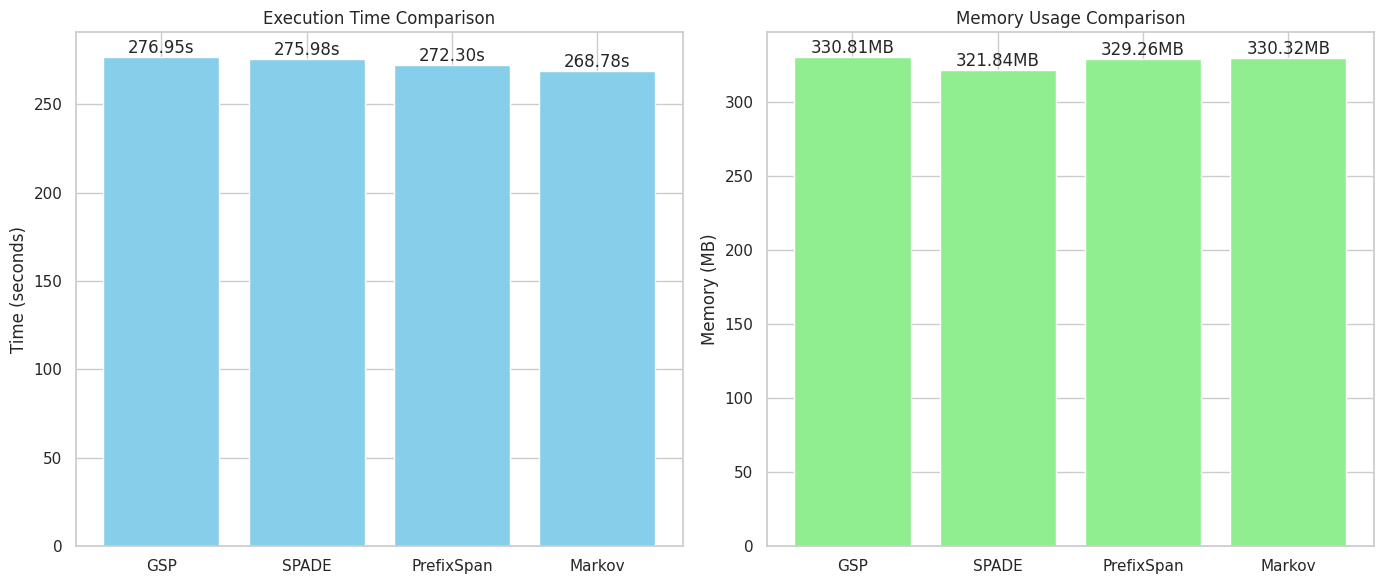

Comparison chart saved to: /content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/performance_comparison.png


In [5]:
import multiprocessing
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

# Add the current directory to Python path
sys.path.append('/content')

# Import the main functions from each algorithm file
from gsp import main as gsp_main
from spade import main as spade_main
from prefix import main as prefix_main
from markov import main as markov_main

# Configuration for results directory
RESULTS_DIR = "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results"
ALGO_DIRS = {
    "GSP": "GSP",
    "SPADE": "SPADE",
    "PrefixSpan": "PrefixSpan",
    "Markov": "MarkovChain"  # Match your actual directory name
}

def run_algorithm(algorithm_name, algorithm_func):
    """Wrapper function to execute an algorithm and collect its metrics."""
    try:
        print(f"Starting {algorithm_name}...")
        algorithm_func()  # Execute the algorithm's main function

        # Construct the correct metrics file path
        metrics_file = os.path.join(
            RESULTS_DIR,
            ALGO_DIRS[algorithm_name],
            f"{algorithm_name.lower()}_metrics.csv"
        )

        metrics_df = pd.read_csv(metrics_file)

        time_taken = metrics_df['Time'].iloc[0]
        memory_used = metrics_df['Memory'].iloc[0]

        print(f"{algorithm_name} completed successfully.")
        return (algorithm_name, time_taken, memory_used)
    except Exception as e:
        print(f"Error running {algorithm_name}: {str(e)}")
        return (algorithm_name, 0, 0)

def visualize_comparison(results):
    """Generate comparison charts for execution time and memory usage."""
    df = pd.DataFrame(results, columns=['Algorithm', 'Time', 'Memory'])

    plt.figure(figsize=(14, 6))

    # Execution time comparison
    plt.subplot(1, 2, 1)
    bars = plt.bar(df['Algorithm'], df['Time'], color='skyblue')
    plt.title('Execution Time Comparison')
    plt.ylabel('Time (seconds)')

    # Add labels on bars for time
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}s',
                 ha='center', va='bottom')

    # Memory usage comparison
    plt.subplot(1, 2, 2)
    bars = plt.bar(df['Algorithm'], df['Memory'], color='lightgreen')
    plt.title('Memory Usage Comparison')
    plt.ylabel('Memory (MB)')

    # Add labels on bars for memory usage
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}MB',
                 ha='center', va='bottom')

    plt.tight_layout()
    comparison_path = os.path.join(RESULTS_DIR, "performance_comparison.png")
    plt.savefig(comparison_path)
    plt.show()
    print(f"Comparison chart saved to: {comparison_path}")

if __name__ == "__main__":
    # Define algorithms and their corresponding main functions
    algorithms = [
        ("GSP", gsp_main),
        ("SPADE", spade_main),
        ("PrefixSpan", prefix_main),
        ("Markov", markov_main),
    ]

    # Run algorithms in parallel using multiprocessing
    with multiprocessing.Pool(processes=4) as pool:
        results = pool.starmap(run_algorithm, algorithms)

    # Save results to a CSV file for analysis
    results_df = pd.DataFrame(results, columns=['Algorithm', 'Time', 'Memory'])
    csv_path = os.path.join(RESULTS_DIR, "algorithm_performance.csv")
    results_df.to_csv(csv_path, index=False)

    print("\nPerformance Results:")
    print(results_df)
    print(f"\nResults CSV saved to: {csv_path}")

    # Generate comparison charts
    visualize_comparison(results)


In [22]:
!pip install pymining

# Model prediction


In [24]:
!pip install streamlit pyngrok pandas matplotlib psutil chromadb --quiet


In [25]:
!pip install -U chromadb


In [26]:
!ngrok authtoken "2rvZItIj18POKjF5bz6iFaRURJv_rAUhzy78oV5euwJYFyDE" # Replace <your_authtoken> with your actual authtoken.


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [32]:
### writing in db
%%writefile app.py

import streamlit as st
import os
import re
import chromadb
from PIL import Image
from datetime import datetime

# Initialize ChromaDB client and collection
client = chromadb.Client()
collection = client.get_or_create_collection(name="engagement_patterns")

# Define markdown file paths for each algorithm
MD_FILE_PATHS = {
    "GSP": "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/GSP/sequential_pattern_analysis_report.md",
    "SPADE": "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/SPADE/spade_sequential_pattern_analysis_report.md",
    "PrefixSpan": "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/PrefixSpan/prefixspan_sequential_pattern_analysis_report.md",
    "Markov": "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/MarkovChain/high_engagement_cluster_markov_chain_analysis_report.md"
}

def store_result(input_data, output_data):
    timestamp = datetime.now().isoformat()
    document = {
        "timestamp": timestamp,
        "input": input_data,
        "output": output_data
    }
    collection.add(documents=[str(document)], ids=[timestamp])
    return timestamp

# Extract patterns for GSP, SPADE, and PrefixSpan
def extract_pattern_general(md_file_path, gender, post_type):
    best_pattern = None
    highest_lift = 0.0
    try:
        with open(md_file_path, "r") as md_file:
            content = md_file.read()
            pattern_regex = re.compile(
                r"Pattern \d+:(.*?)\n"
                r"- Support: (.*?)\n"
                r"- Confidence: (.*?)\n"
                r"- Lift: (.*?)\n"
                r"- Most Common Post Type: (.*?)\n"
                r"- Most Common Gender: (.*?)\n"
                r"- Sequence Count: (.*?)\n",
                re.DOTALL
            )
            matches = pattern_regex.findall(content)
            for match in matches:
                pattern_text = match[0].strip()
                support = float(match[1].strip())
                confidence = float(match[2].strip())
                lift = float(match[3].strip())
                pattern_post_type = match[4].strip().lower()
                pattern_gender = match[5].strip().lower()
                sequence_count = int(match[6].strip())
                if pattern_post_type == post_type.lower() and pattern_gender == gender.lower():
                    if lift > highest_lift:
                        highest_lift = lift
                        best_pattern = {
                            "Pattern": pattern_text,
                            "Support": support,
                            "Confidence": confidence,
                            "Lift": lift,
                            "Post Type": pattern_post_type.title(),
                            "Gender": pattern_gender.title(),
                            "Sequence Count": sequence_count
                        }
    except Exception as e:
        st.error(f"Error extracting general pattern: {e}")
    return best_pattern

# Extract patterns for Markov
def extract_pattern_markov(md_file_path, gender, post_type):
    try:
        with open(md_file_path, "r") as file:
            content = file.read()
        sections = re.findall(r"### State: (.*?)\n(.*?)\n(?=###|##|$)", content, re.DOTALL)
        for state, data in sections:
            gender_match = re.search(r"Most common gender: (.*?)\n", data)
            post_type_match = re.search(r"Most common post type: (.*?)\n", data)
            if gender_match and post_type_match:
                common_gender = gender_match.group(1).strip().lower()
                common_post_type = post_type_match.group(1).strip().lower()
                if common_gender == gender.lower() and common_post_type == post_type.lower():
                    expected_visits_match = re.search(r"Expected visits: (.*?)\n", data)
                    return {
                        "State": state.strip(),
                        "Expected Visits": float(expected_visits_match.group(1).strip()) if expected_visits_match else "N/A",
                        "Post Type": post_type.title(),
                        "Gender": gender.title()
                    }
    except Exception as e:
        st.error(f"Error extracting Markov pattern: {e}")
    return None

# Main UI
def main():
    st.set_page_config(page_title="📊 Engagement Pattern Analyzer", layout="wide")

    # Display image banner if available
    banner_path = "/content/drive/MyDrive/SEM8/DataMining/PROJECT/User_Management_Analysis/engagement_analysis_results/banner.png"
    if os.path.exists(banner_path):
        st.image(Image.open(banner_path), use_column_width=True)

    st.markdown("""
        <h1 style='text-align: center; color: #4CAF50;'>📊 Engagement Pattern Analyzer</h1>
        <p style='text-align: center;'>Discover engagement-driving patterns across different algorithms by selecting audience and content type preferences.</p>
    """, unsafe_allow_html=True)

    with st.sidebar:
        st.header("🔧 Filters")
        algorithm = st.selectbox("Select Algorithm", list(MD_FILE_PATHS.keys()))
        gender = st.selectbox("Select Audience Gender", ["Male", "Female", "Other"])
        post_type = st.selectbox("Select Post Type", ["Video", "Image", "Link"])
        if st.button("🔍 Find Pattern"):
            st.session_state.query = (algorithm, gender, post_type)

    if "query" in st.session_state:
        algorithm, gender, post_type = st.session_state.query
        md_path = MD_FILE_PATHS[algorithm]
        result = None
        if algorithm == "Markov":
            result = extract_pattern_markov(md_path, gender, post_type)
        else:
            result = extract_pattern_general(md_path, gender, post_type)

        if result:
            st.success("✅ Matching Pattern Found:")
            for k, v in result.items():
                st.markdown(f"**{k}:** {v}")
            # Save to ChromaDB
            doc_id = store_result({"Algorithm": algorithm, "Gender": gender, "Post Type": post_type}, result)
            st.info(f"🧠 Result stored in database with ID: {doc_id}")
        else:
            st.warning("❌ No matching pattern found in the report.")

if __name__ == "__main__":
    main()


Overwriting app.py


In [33]:
!pip install streamlit pyngrok --quiet
from pyngrok import ngrok
import threading
import time
import os

ngrok.set_auth_token("2rvZItIj18POKjF5bz6iFaRURJv_rAUhzy78oV5euwJYFyDE")
ngrok.kill()

def run():
    os.system('streamlit run app.py --server.port 8501')

thread = threading.Thread(target=run)
thread.start()

time.sleep(5)
public_url = ngrok.connect(8501)
print(f"🌐 Open the app at: {public_url}")


🌐 Open the app at: NgrokTunnel: "https://7ea8-35-229-125-133.ngrok-free.app" -> "http://localhost:8501"


In [34]:
import chromadb
from chromadb.config import Settings

PERSIST_DIR = "/content/chroma_db"

# Remove persist_directory and pass Settings to the constructor
client = chromadb.Client(Settings(persist_directory=PERSIST_DIR))

collection = client.get_or_create_collection("engagement_patterns")
data = collection.get()

if data["ids"]:
    for doc_id, doc in zip(data["ids"], data["documents"]):
        print(f"🆔 ID: {doc_id}")
        print(f"📄 Document: {doc}")
else:
    print("🗃️ No documents found in the ChromaDB collection.")

🗃️ No documents found in the ChromaDB collection.
